In [23]:
import os
os.environ.pop("MPLBACKEND", None)  

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
print("matplotlib backend AVANT:", matplotlib.get_backend())

#  backend inline
matplotlib.use("module://matplotlib_inline.backend_inline", force=True)

import matplotlib.pyplot as plt
from IPython.display import display
plt.ioff()                 
plt.show = lambda *a, **k: None  # neutralise toute ouverture de fenêtre par plt.show()

print("matplotlib backend APRES:", matplotlib.get_backend())

# --- 1) imports projet ---
from datetime import date, datetime
print("Running date:", date.today().strftime("%B %d, %Y"))

import pyleecan, SciDataTool
from pyleecan.Functions.load import load

print("Pyleecan version:", pyleecan.__version__)
print("SciDataTool version:", SciDataTool.__version__)



matplotlib backend AVANT: module://matplotlib_inline.backend_inline
matplotlib backend APRES: module://matplotlib_inline.backend_inline
Running date: October 13, 2025
Pyleecan version: 1.5.2
SciDataTool version: 2.5.0


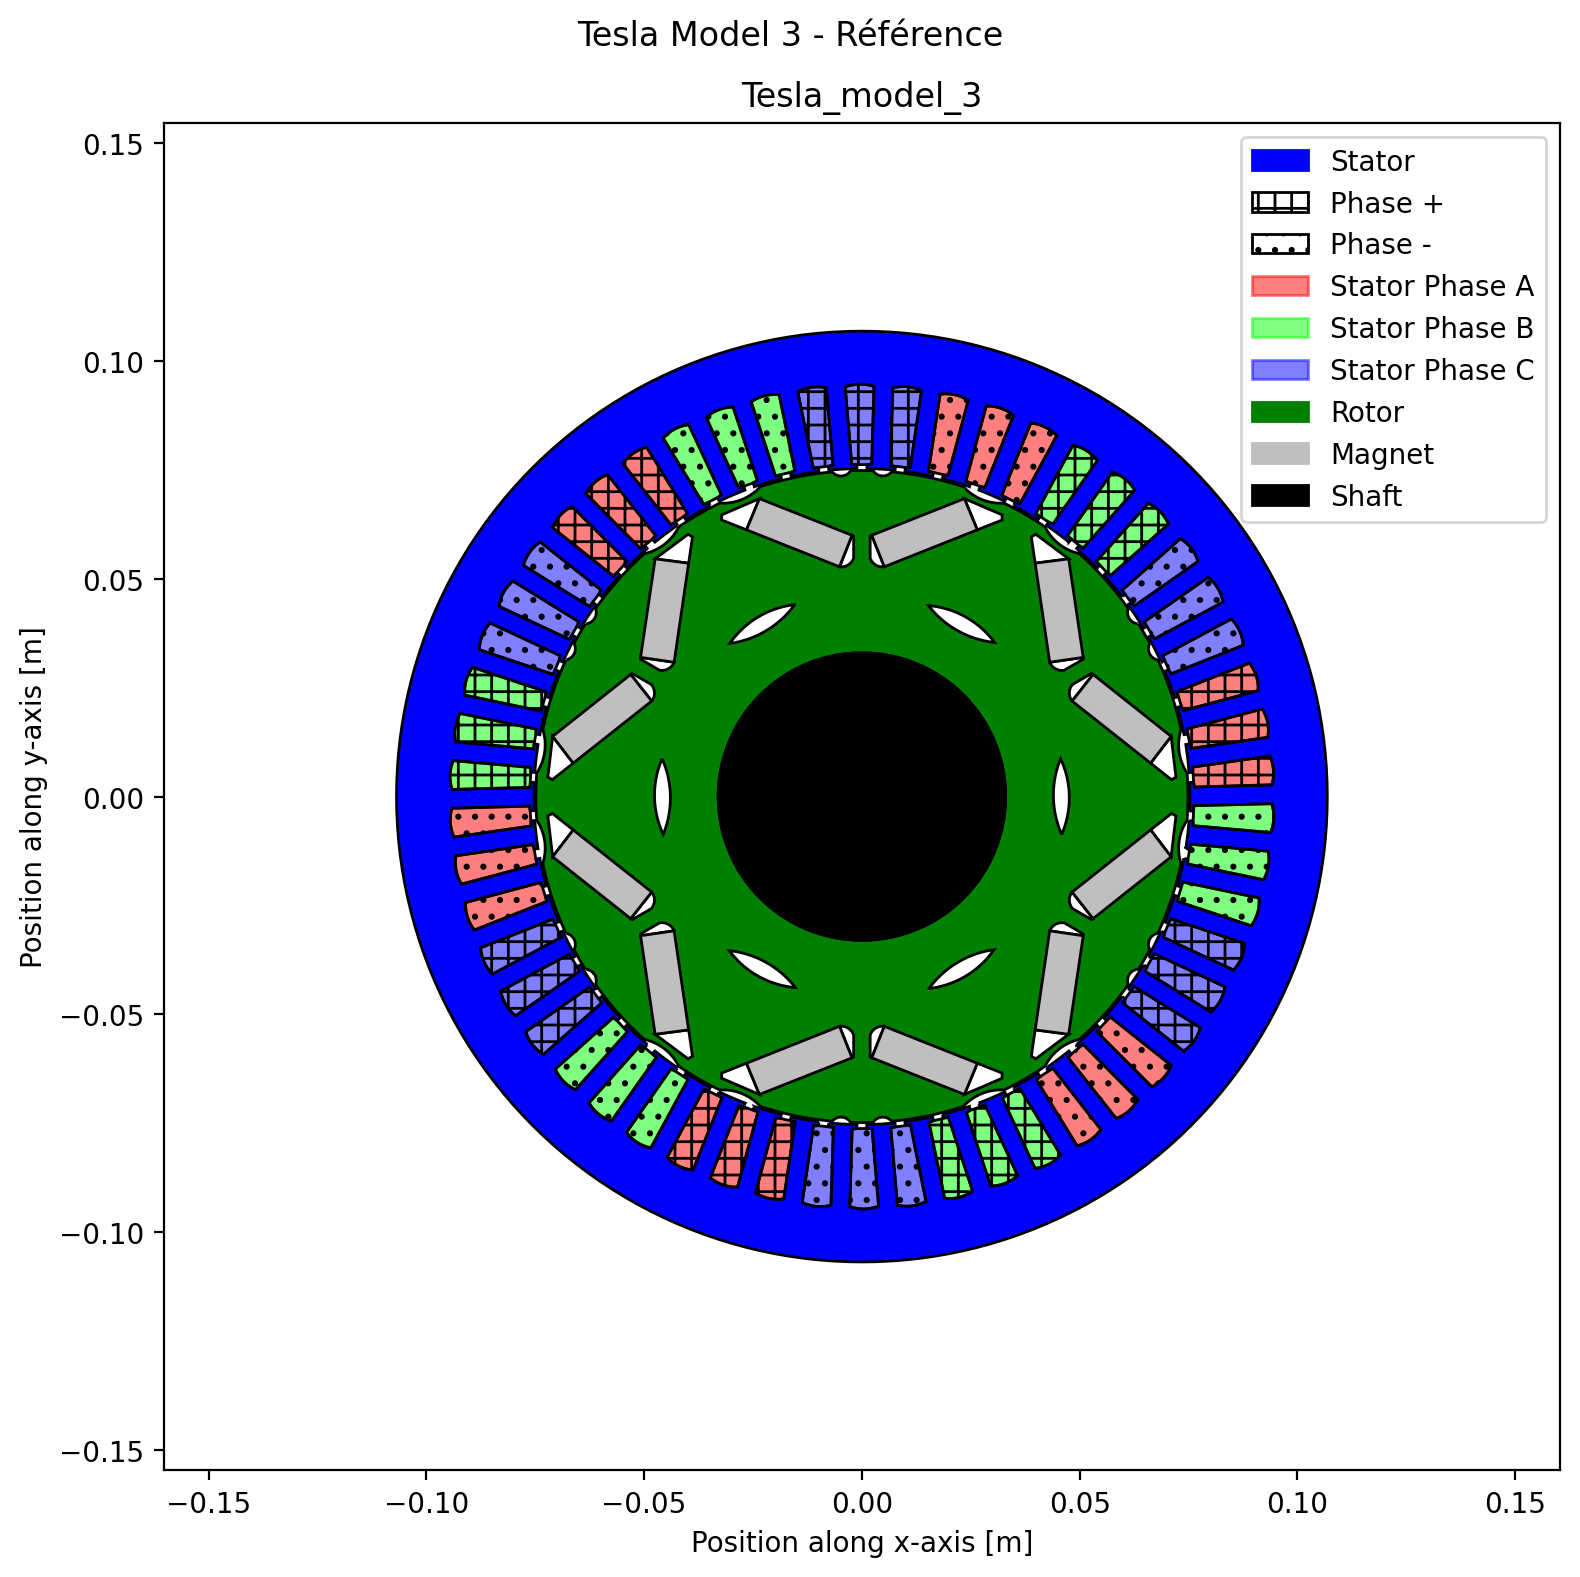

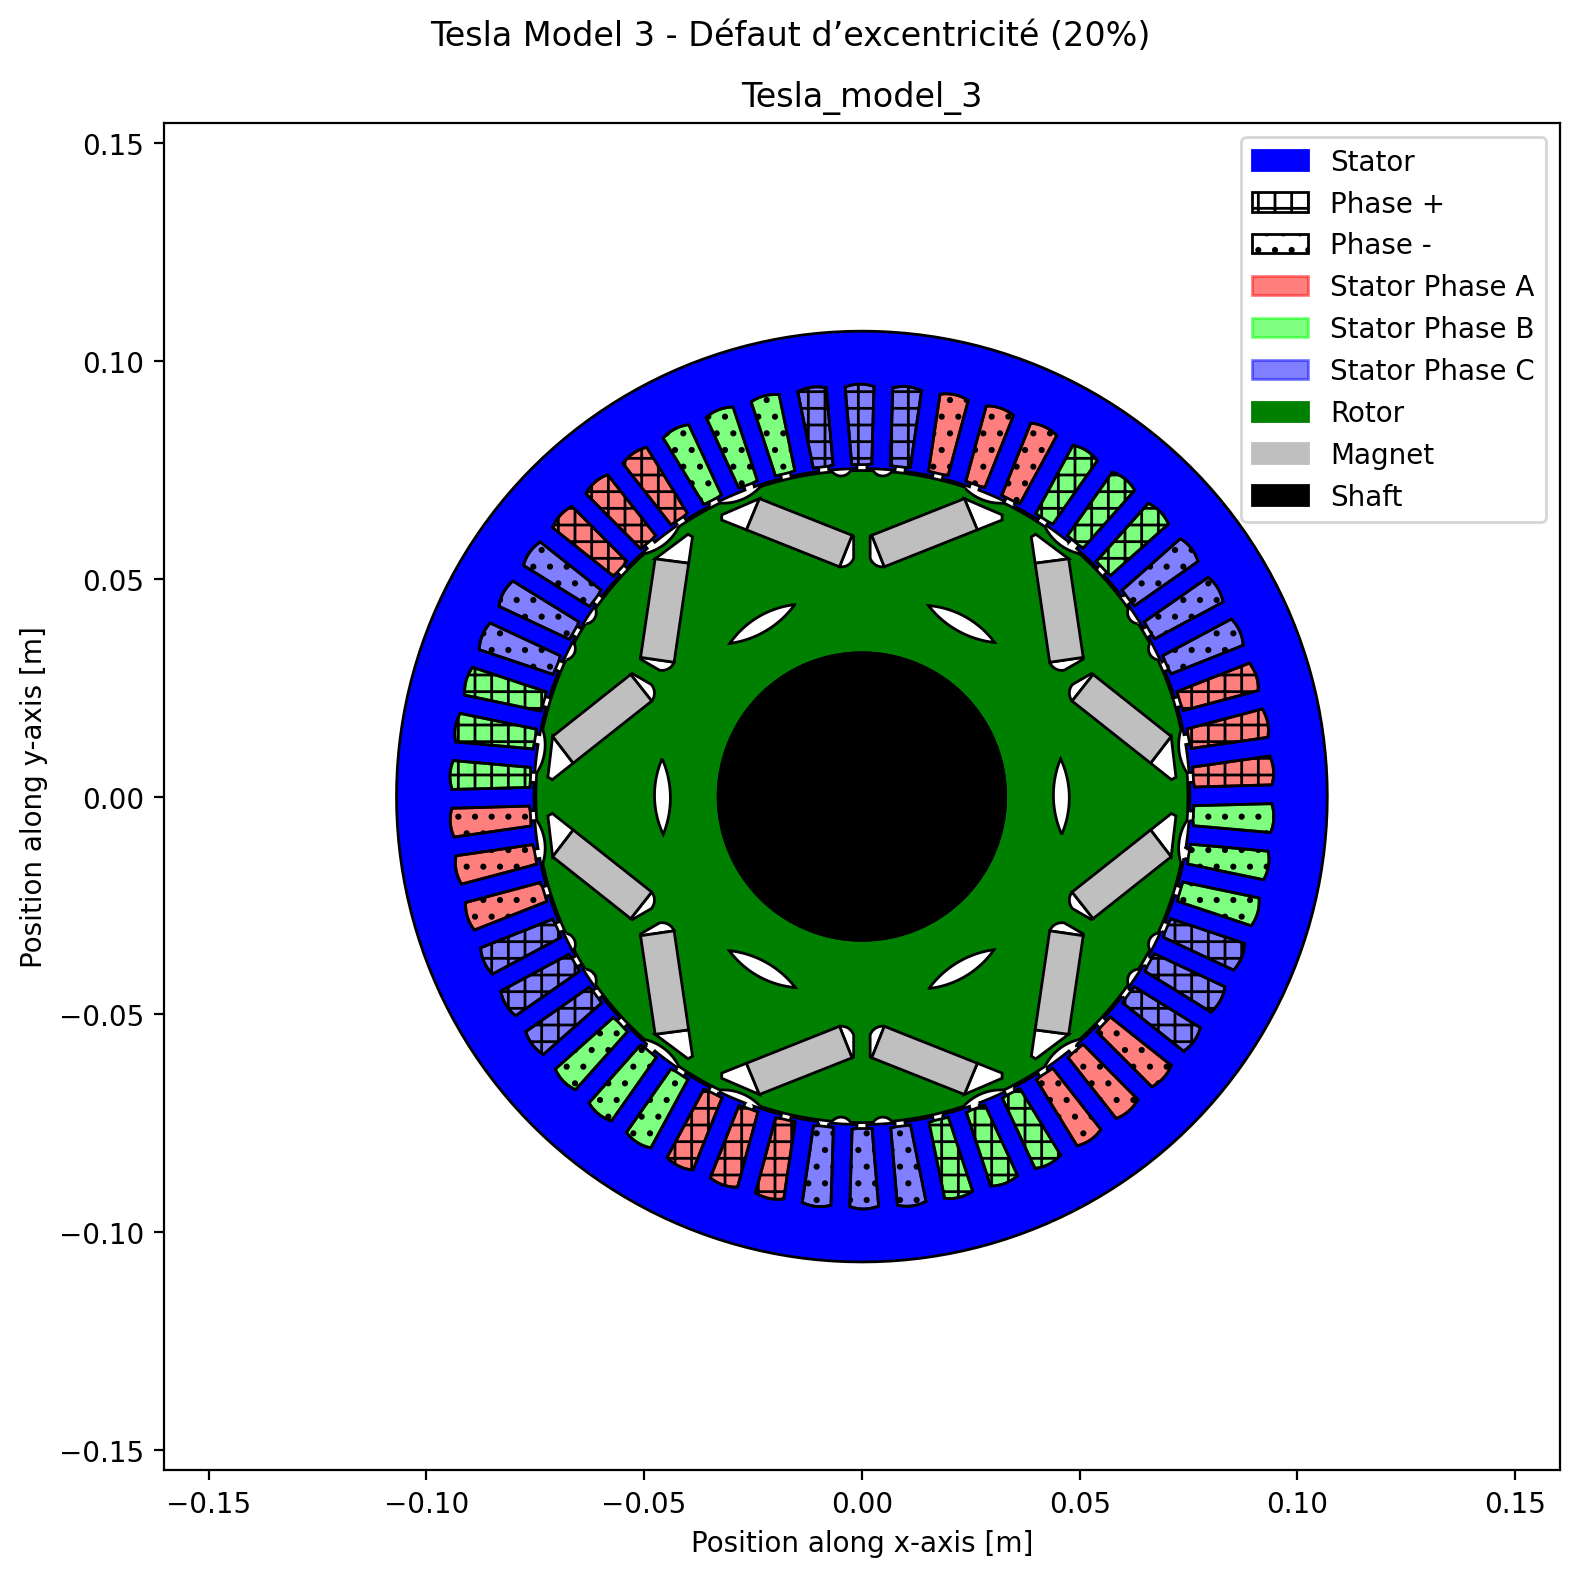

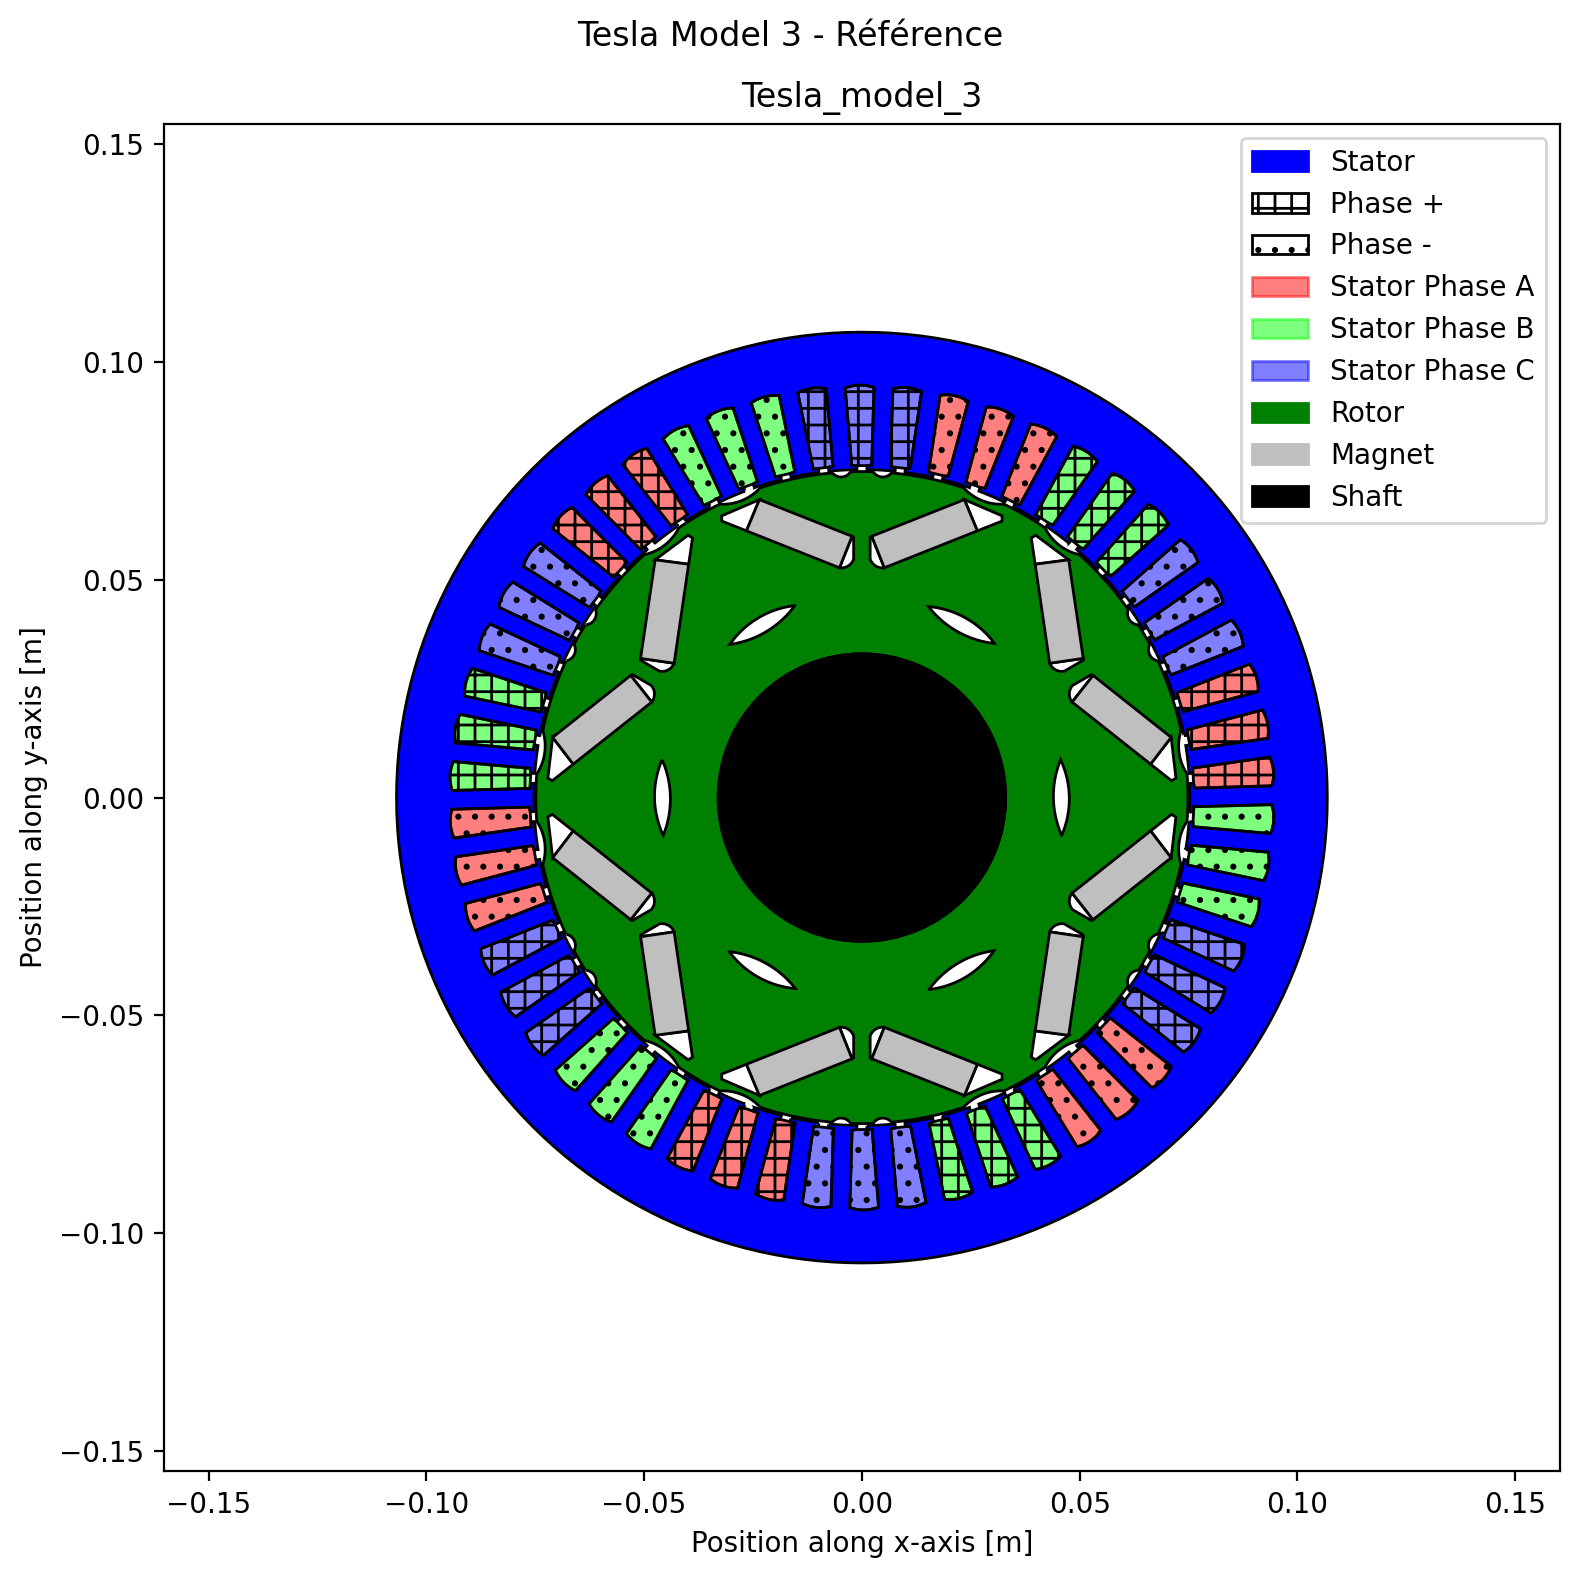

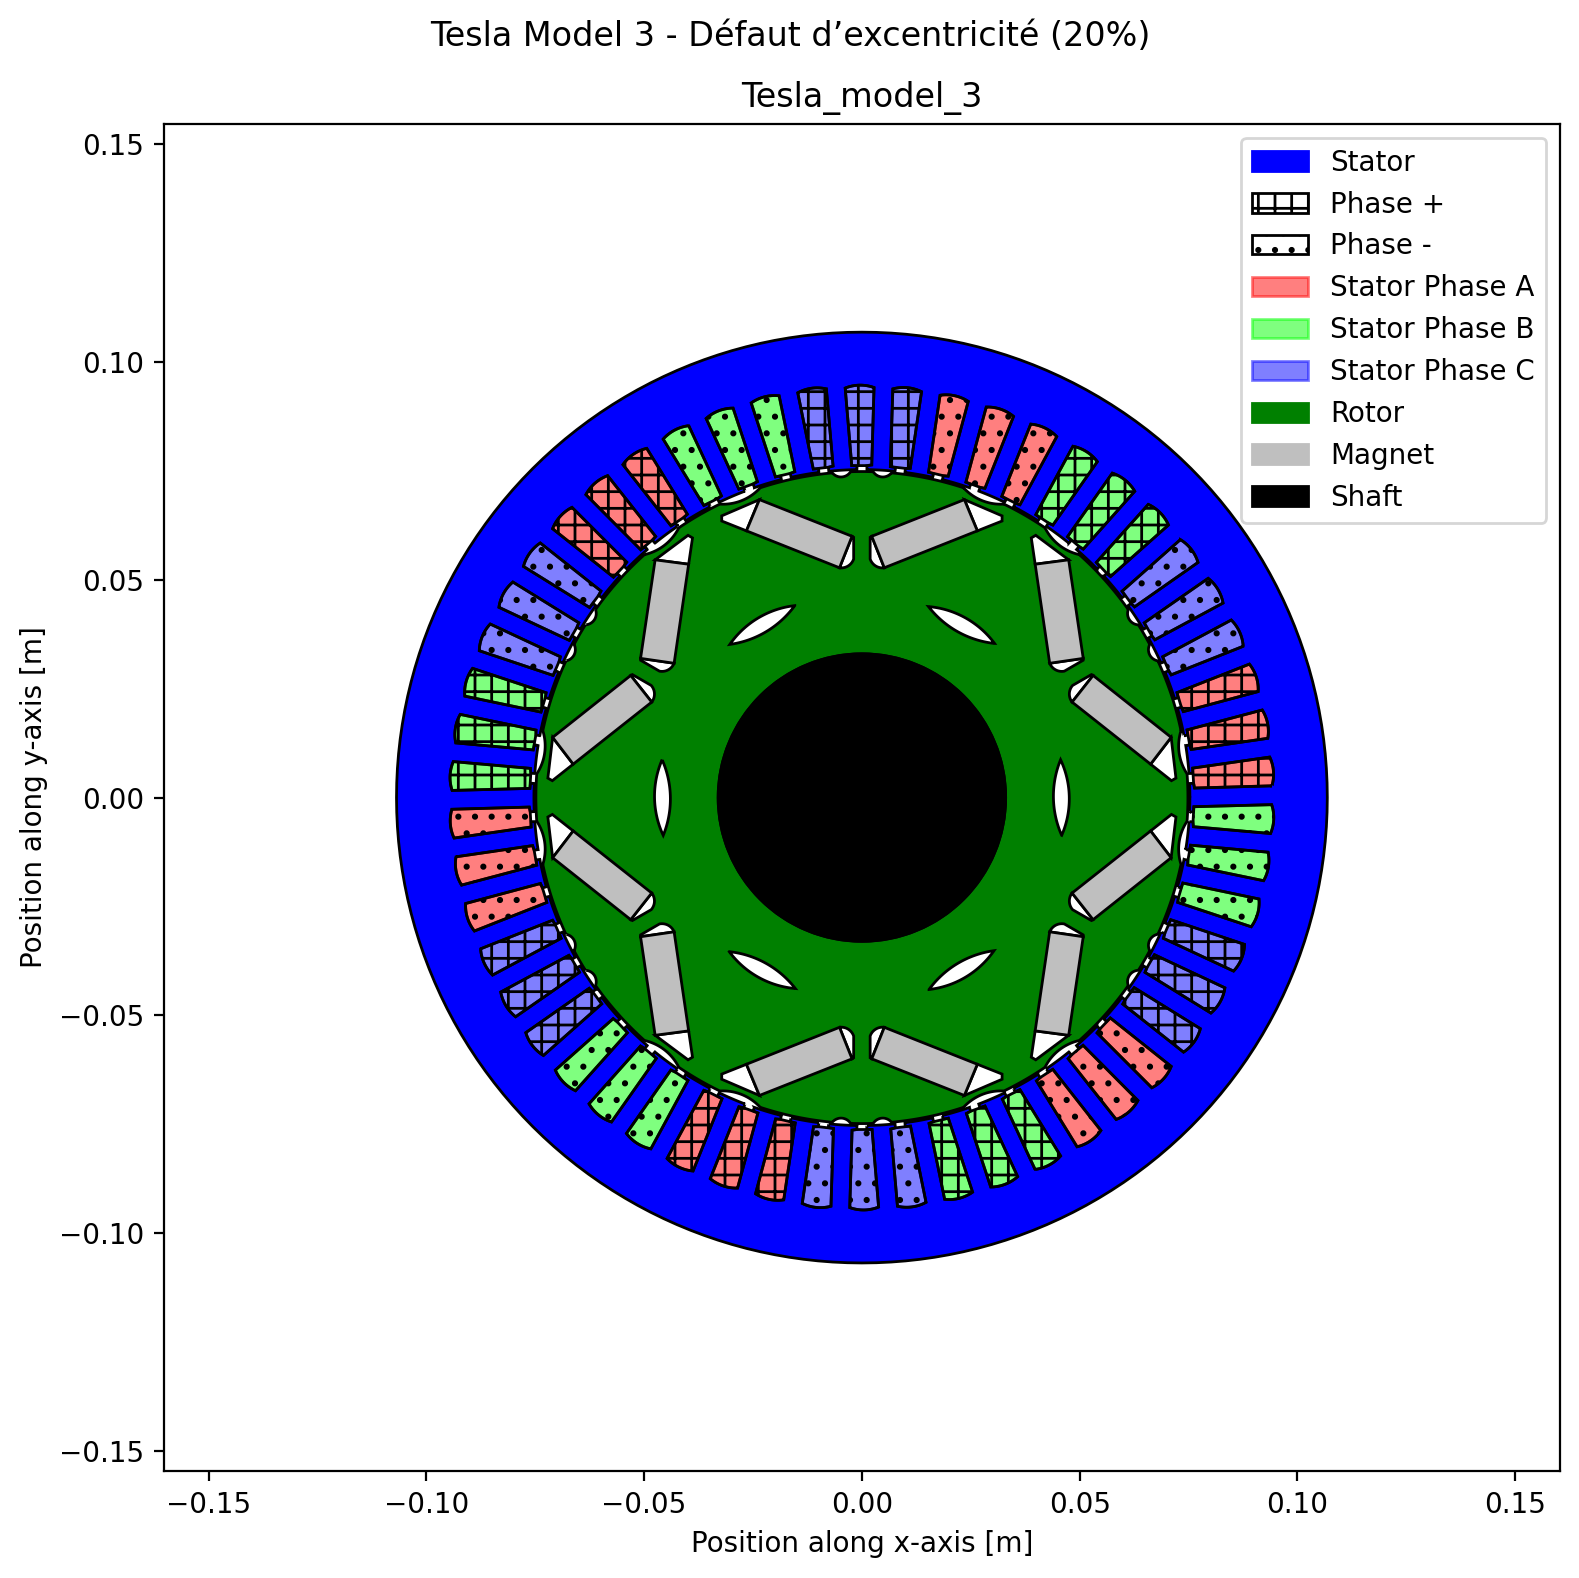

In [24]:
%matplotlib inline
# Nettoyage des anciennes figures
plt.close('all')

# Chargement de la machine de référence
M_ref = load("machine_defaut_excentricite/Tesla_Model3_Reference.json")
fig1, ax1 = M_ref.plot(is_show_fig=False) if 'is_show_fig' in M_ref.plot.__code__.co_varnames else M_ref.plot()
fig1.suptitle("Tesla Model 3 - Référence")
display(fig1)

# Chargement de la machine avec défaut d’excentricité
M_ecc = load("machine_defaut_excentricite/Tesla_Model3_Defaut_Excentricite_20Pourcent.json")
fig2, ax2 = M_ecc.plot(is_show_fig=False) if 'is_show_fig' in M_ecc.plot.__code__.co_varnames else M_ecc.plot()
fig2.suptitle("Tesla Model 3 - Défaut d’excentricité (20%)")
display(fig2)

In [25]:
# === 3. INITIALISATION DE LA SIMULATION ===
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM

# Simulation magnétique pour Tesla Model 3 (référence)
simu_ref = Simu1(name="Tesla_Model3_Ref", machine=M_ref)

# Définition du module magnétique (FEMM)
simu_ref.mag = MagFEMM(
    type_BH_stator=0,   # Pas de BH curve (linéaire)
    type_BH_rotor=0,    # idem pour rotor
    is_periodicity_a=True,  # symétrie angulaire
    is_periodicity_t=True,  # symétrie temporelle
    nb_worker=4,        # parallélisation
    Kgeo_fineness=1,    # finesse maillage géométrique
)

# On ne fait que la simulation magnétique
simu_ref.elec = None
simu_ref.force = None
simu_ref.struct = None


In [26]:
# Simulation magnétique pour la machine excentrée
simu_ecc = Simu1(name="Tesla_Model3_Ecc20", machine=M_ecc)
simu_ecc.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    Kgeo_fineness=1,
)
simu_ecc.elec = None
simu_ecc.force = None
simu_ecc.struct = None


In [27]:
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from numpy import sqrt, exp, pi

# === 4. DÉFINITION DU POINT DE FONCTIONNEMENT ===
# Courant sinusoïdal défini par (I0, Phi0)

# Amplitude RMS du courant 
I0_rms = 250 / sqrt(2)   # [Arms]
Phi0 = 140 * pi / 180    # Angle du courant pour MTPA (rad)

# Calcul Id/Iq correspondants
Id_ref = (I0_rms * exp(1j * Phi0)).real
Iq_ref = (I0_rms * exp(1j * Phi0)).imag

print(f" Point de fonctionnement choisi :")
print(f"   I0 = {I0_rms:.2f} Arms, Phi0 = {Phi0*180/pi:.1f}°")
print(f"   -> Id = {Id_ref:.2f} Arms, Iq = {Iq_ref:.2f} Arms")

# Application à la simulation de la machine de référence
simu_ref.input = InputCurrent()
simu_ref.input.OP = OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref)

# pour la machine excentrée (20% entrefer)
simu_ecc.input = InputCurrent()
simu_ecc.input.OP = OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref)


 Point de fonctionnement choisi :
   I0 = 176.78 Arms, Phi0 = 140.0°
   -> Id = -135.42 Arms, Iq = 113.63 Arms


In [28]:
# DÉFINITION DU POINT DE FONCTIONNEMENT
# ================================

# Nombre de pas temporels sur une période électrique
simu_ecc.input.Nt_tot = 128      #  compromis précision/temps

# Discrétisation spatiale (nombre de points sur le périmètre)
simu_ecc.input.Na_tot = 2048    

# Vitesse de rotation du rotor
simu_ecc.input.OP.N0 = 2000      # [tr/min] point de fonctionnement choisi

print("Configuration simulation pour machine excentrée :")
print(f"   Nt_tot = {simu_ecc.input.Nt_tot} pas de temps")
print(f"   Na_tot = {simu_ecc.input.Na_tot} pas spatiaux")
print(f"   N0 = {simu_ecc.input.OP.N0} tr/min")

Configuration simulation pour machine excentrée :
   Nt_tot = 128 pas de temps
   Na_tot = 2048 pas spatiaux
   N0 = 2000 tr/min


In [29]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from numpy import sqrt, exp, pi

# === 1. MACHINE DE RÉFÉRENCE ===

simu_op = Simu1(name="Tesla_ref", machine=M_ref)
simu_op.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    Kgeo_fineness=1,
)
simu_op.elec = None
simu_op.force = None
simu_op.struct = None

# === 2. COURANT D’ENTRÉE (référence) ===
I0_rms = 250/sqrt(2)
Phi0 = 140 * pi / 180
Id_ref = (I0_rms*exp(1j*Phi0)).real
Iq_ref = (I0_rms*exp(1j*Phi0)).imag

simu_op.input = InputCurrent()
simu_op.input.OP = OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref)

# === 3. PARAMÈTRES COMMUNS ===
Nt_tot = 128
Na_tot = 2048
N0_rpm = 2000

simu_op.input.Nt_tot = Nt_tot
simu_op.input.Na_tot = Na_tot
simu_op.input.OP.N0 = N0_rpm

print("Simulation référence prête ")


Simulation référence prête 


In [30]:
from pyleecan.Functions.Plot import dict_2D

# === Lancer la simulation pour la machine de référence ===
out_ref = simu_op.run()

# === Résultats ===
print("\n[RESULTATS - MACHINE REFERENCE]")
print(f"Couple moyen: {out_ref.mag.Tem_av:.2f} Nm")
print(f"Ondulation de couple (peak-to-peak): {out_ref.mag.Tem_rip_pp:.2f} Nm")
print(f"Puissance moyenne: {out_ref.mag.Pem_av:.2f} W")


[14:48:17] Starting running simulation Tesla_ref (machine=Tesla_model_3)
[14:48:18] Starting Magnetic module
[14:48:18] In Magnetic model, Nt_tot=128 is not divisible by the machine time periodicity (3). Time periodicity removed
[14:48:18] In Magnetic model, Na_tot=2048 is not divisible by the machine angular periodicity (3). Angular periodicity removed
[14:48:18] Solving slice 1 / 2
[14:49:15] Solving time steps: 0%
[14:49:16] Solving time steps: 0%
[14:49:16] Solving time steps: 0%
[14:49:17] Solving time steps: 0%
[15:00:49] Solving time steps: 25%
[15:00:50] Solving time steps: 25%
[15:00:53] Solving time steps: 25%
[15:00:53] Solving time steps: 25%
[15:09:33] Solving time steps: 50%
[15:09:39] Solving time steps: 50%
[15:09:40] Solving time steps: 50%
[15:09:41] Solving time steps: 50%
[15:18:25] Solving time steps: 75%
[15:18:27] Solving time steps: 75%
[15:18:29] Solving time steps: 75%
[15:18:44] Solving time steps: 75%
[15:27:01] Solving time step: 100%
[15:27:01] Solving tim

In [31]:
# Simulation sur la machine excentrée
out_ecc = simu_ecc.run()

print("\n[RESULTATS - MACHINE EXCENTREE]")
print(f"Couple moyen: {out_ecc.mag.Tem_av:.2f} Nm")
print(f"Ondulation de couple (peak-to-peak): {out_ecc.mag.Tem_rip_pp:.2f} Nm")
print(f"Puissance moyenne: {out_ecc.mag.Pem_av:.2f} W")


[16:04:37] Starting running simulation Tesla_Model3_Ecc20 (machine=Tesla_model_3)
[16:04:37] Starting Magnetic module
[16:04:37] In Magnetic model, Nt_tot=128 is not divisible by the machine time periodicity (3). Time periodicity removed
[16:04:37] In Magnetic model, Na_tot=2048 is not divisible by the machine angular periodicity (3). Angular periodicity removed
[16:04:38] Solving slice 1 / 2
[16:05:31] Solving time steps: 0%
[16:05:32] Solving time steps: 0%
[16:05:33] Solving time steps: 0%
[16:05:33] Solving time steps: 0%
[16:16:51] Solving time steps: 25%
[16:16:58] Solving time steps: 25%
[16:17:01] Solving time steps: 25%
[16:17:04] Solving time steps: 25%
[16:25:08] Solving time steps: 50%
[16:25:12] Solving time steps: 50%
[16:25:20] Solving time steps: 50%
[16:25:22] Solving time steps: 50%
[16:32:39] Solving time steps: 75%
[16:32:52] Solving time steps: 75%
[16:32:52] Solving time steps: 75%
[16:32:56] Solving time steps: 75%
[16:40:09] Solving time step: 100%
[16:40:27] So


[GRAPHIQUES - MACHINE REFERENCE]


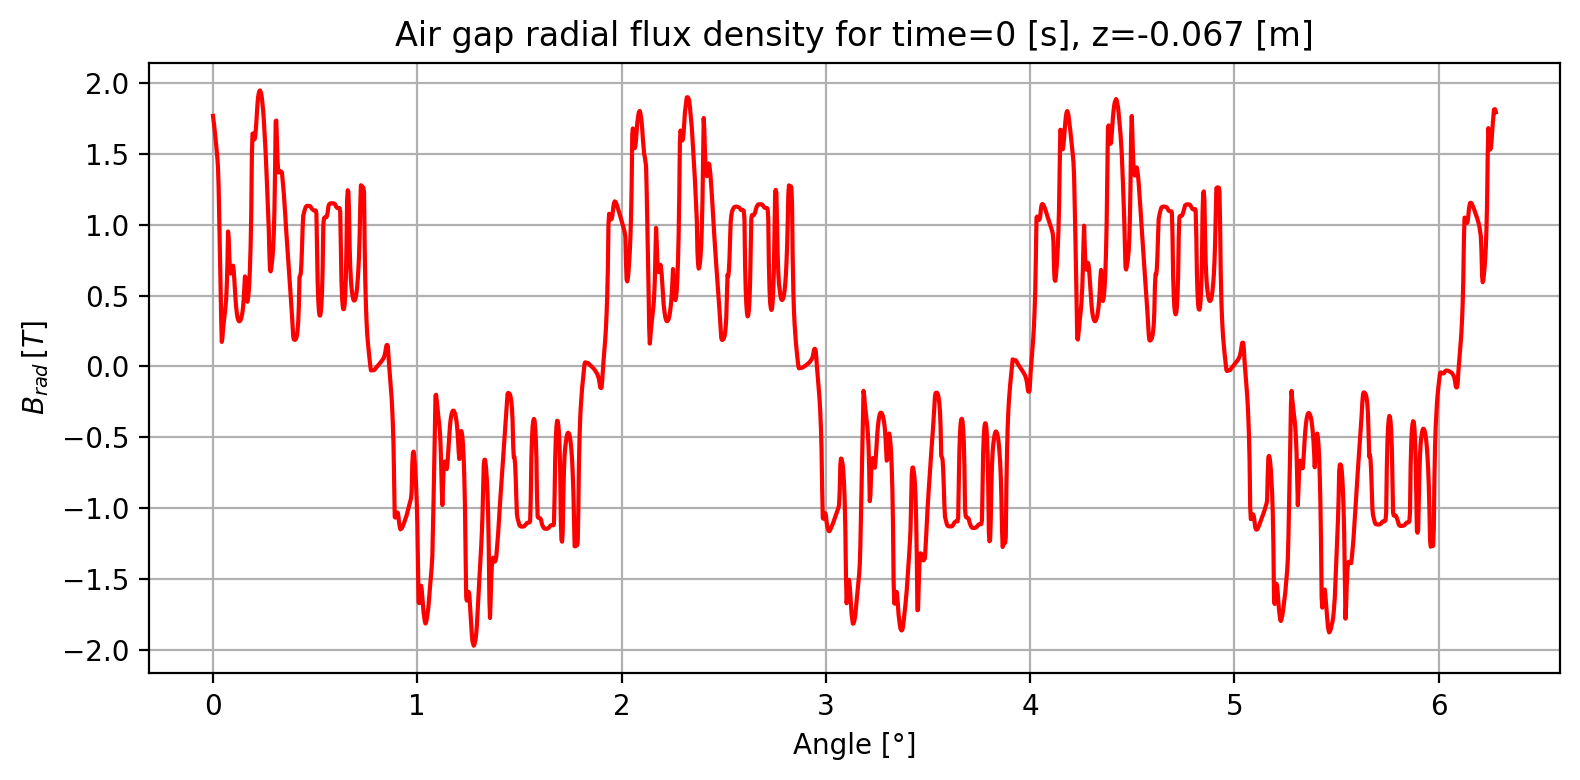

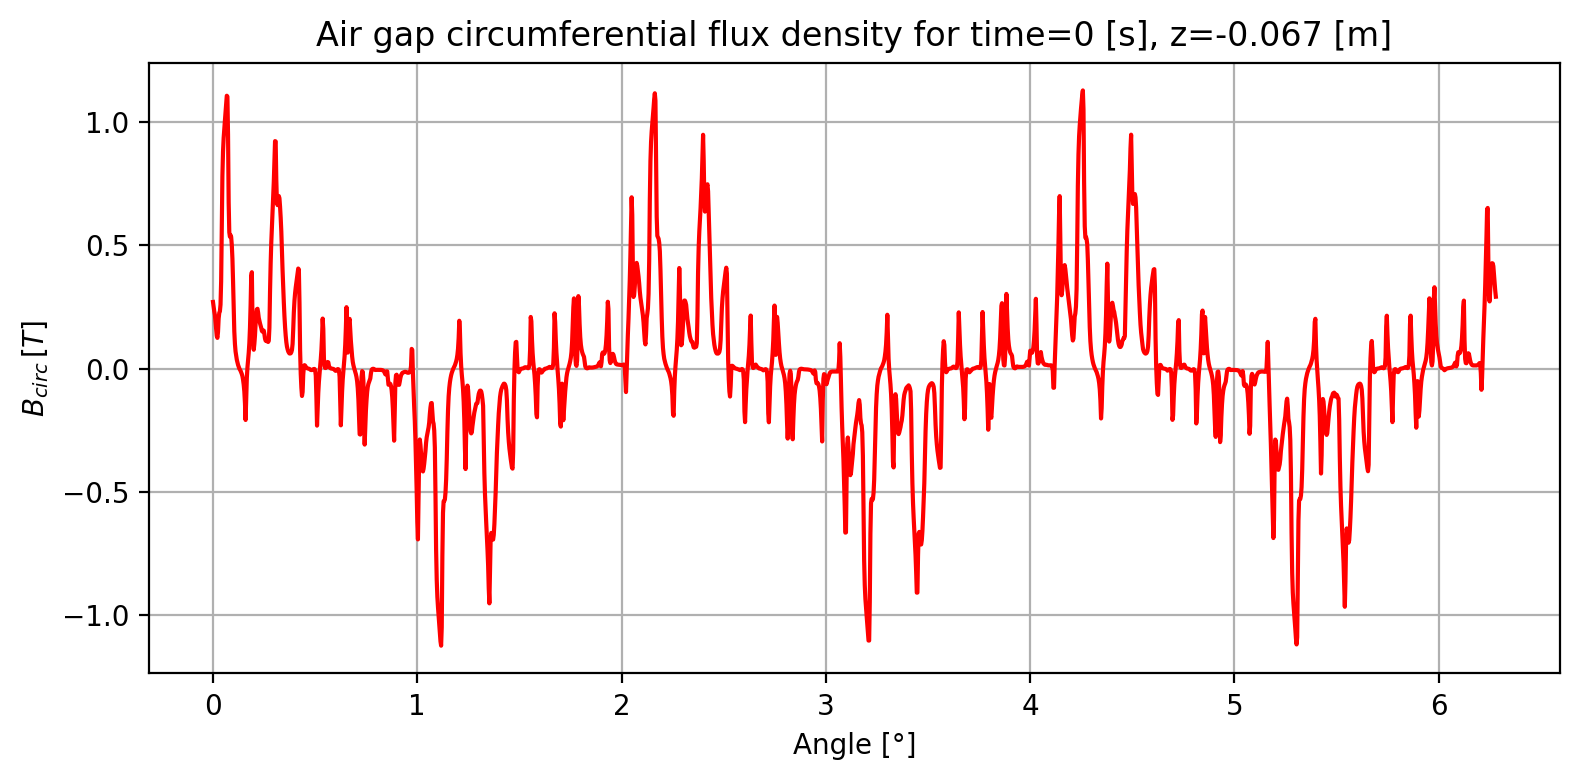

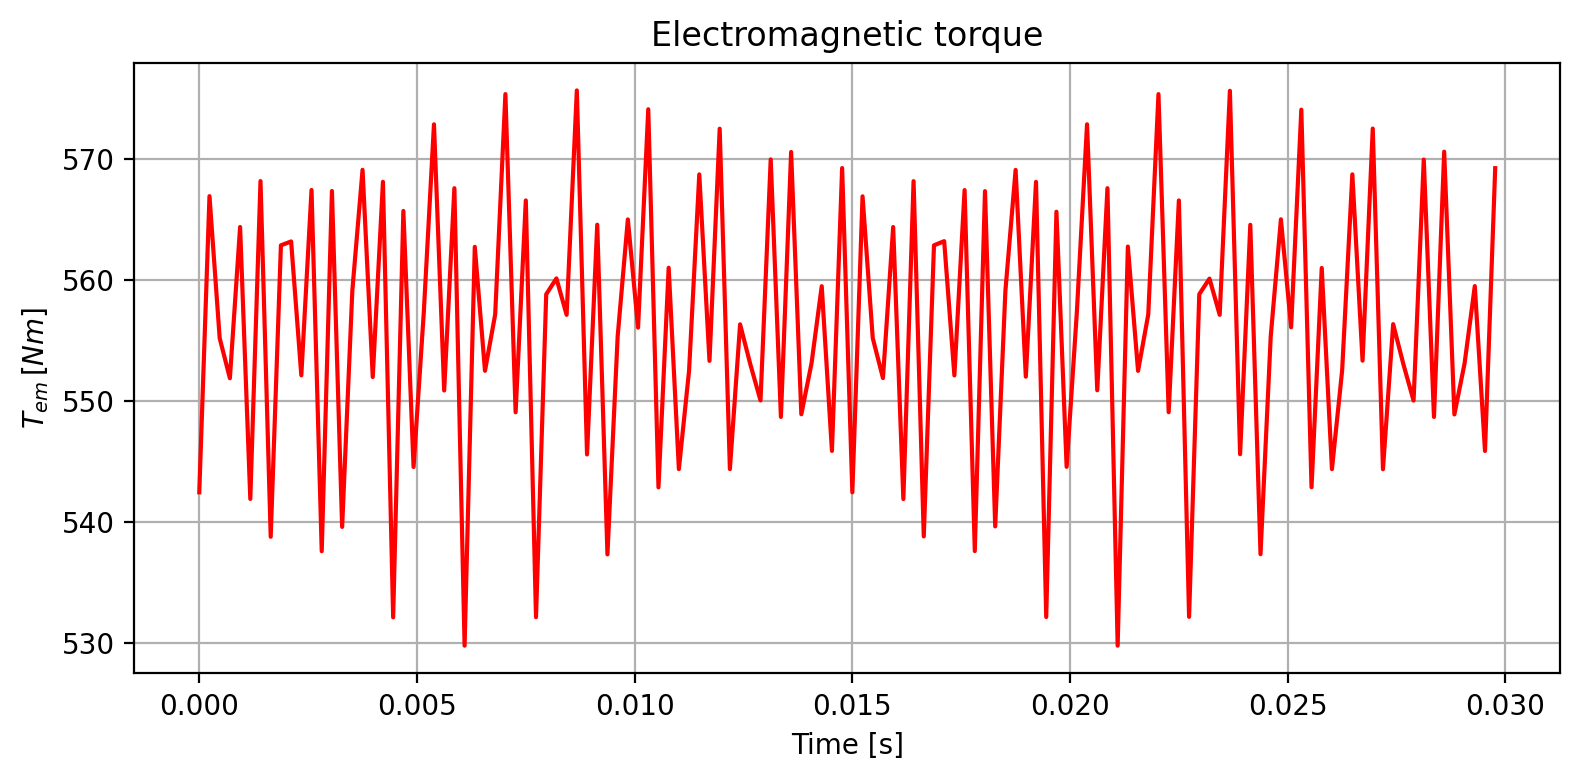

In [32]:
print("\n[GRAPHIQUES - MACHINE REFERENCE]")

# Flux d'entrefer en fonction de l'angle
out_ref.mag.B.plot_2D_Data("angle", **dict_2D)

# Couple électromagnétique en fonction du temps
out_ref.mag.Tem.plot_2D_Data("time", **dict_2D)



[GRAPHIQUES - MACHINE EXCENTREE]


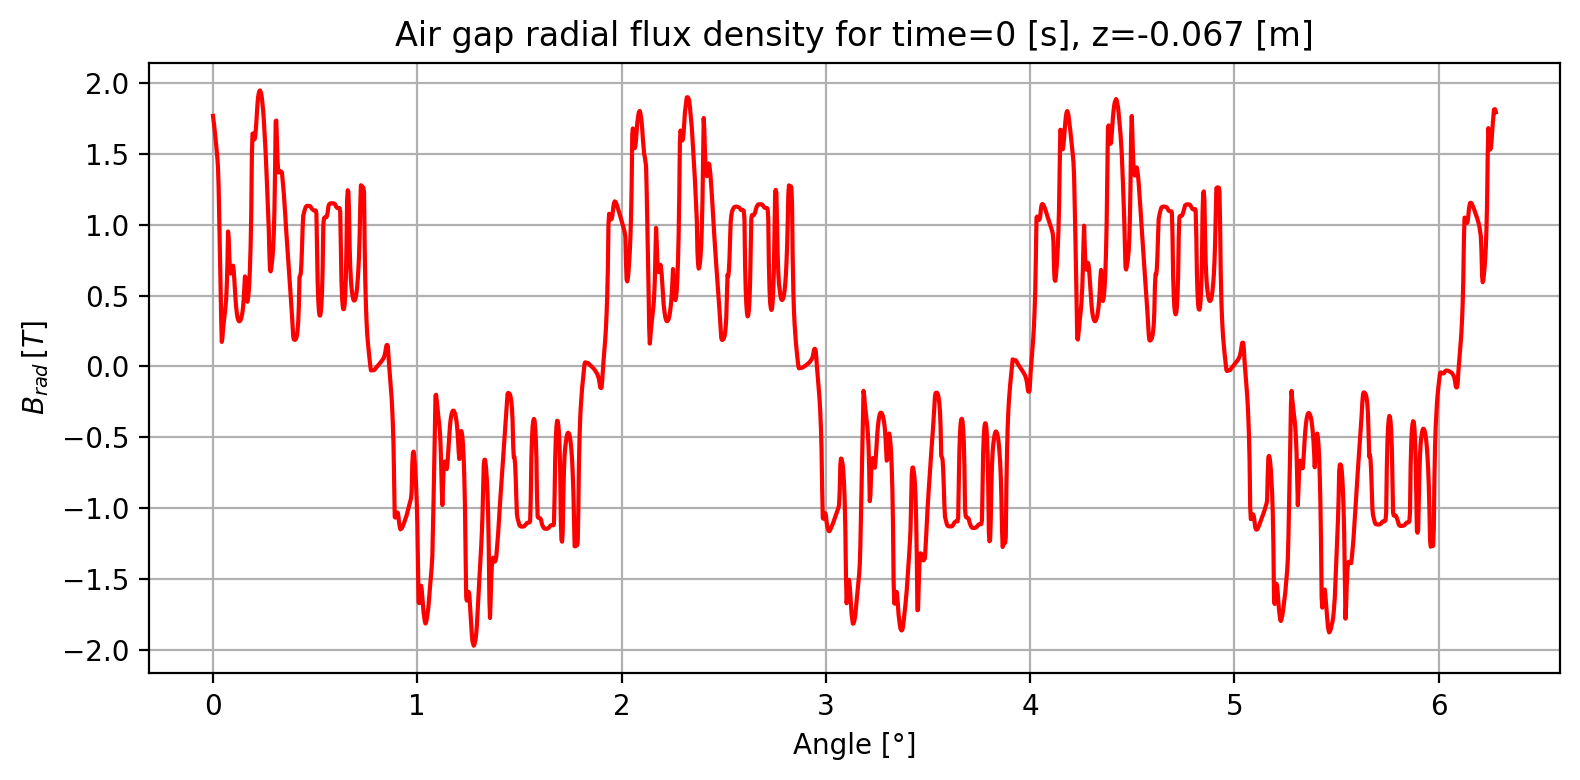

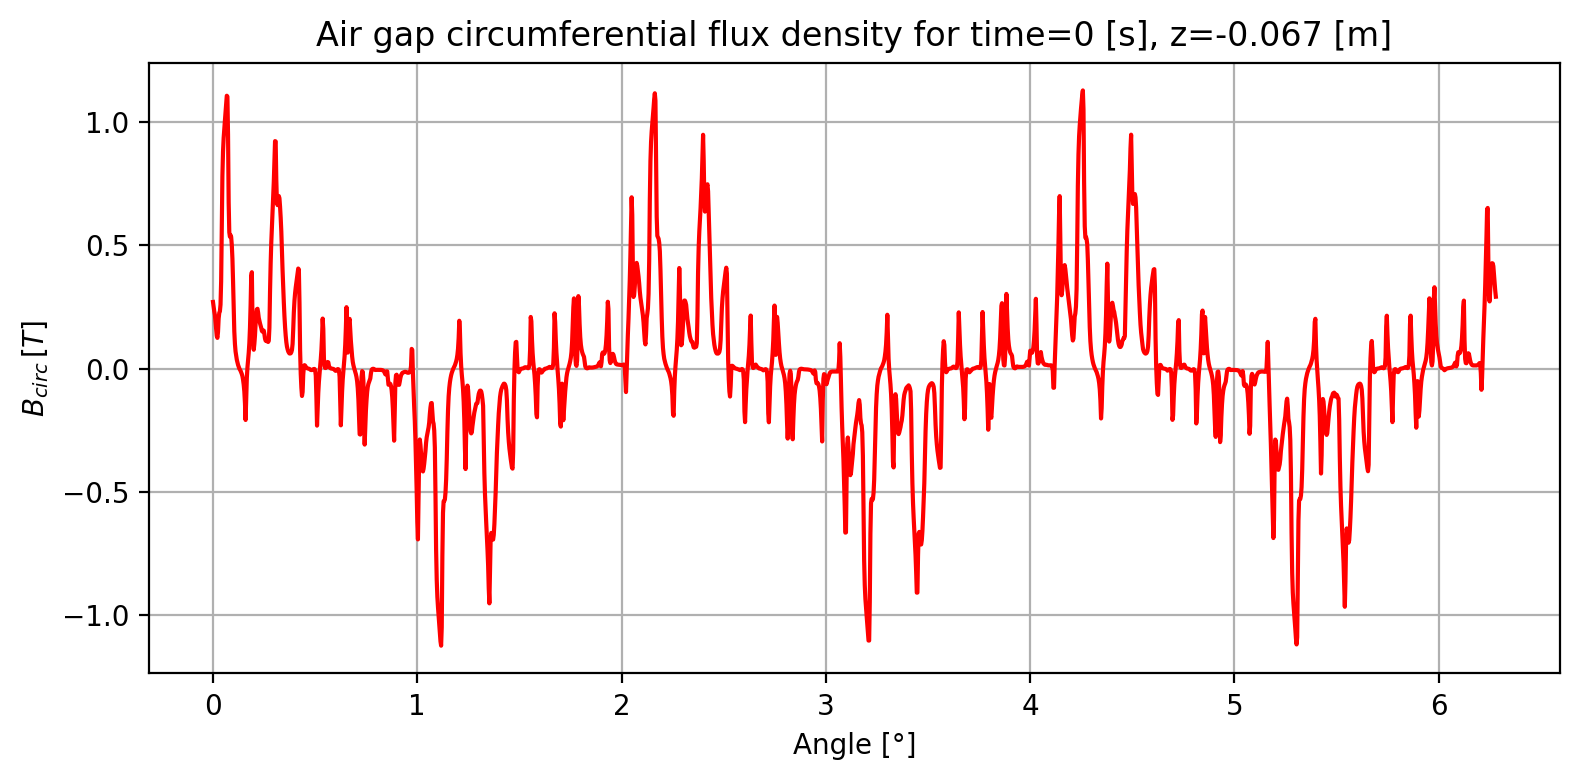

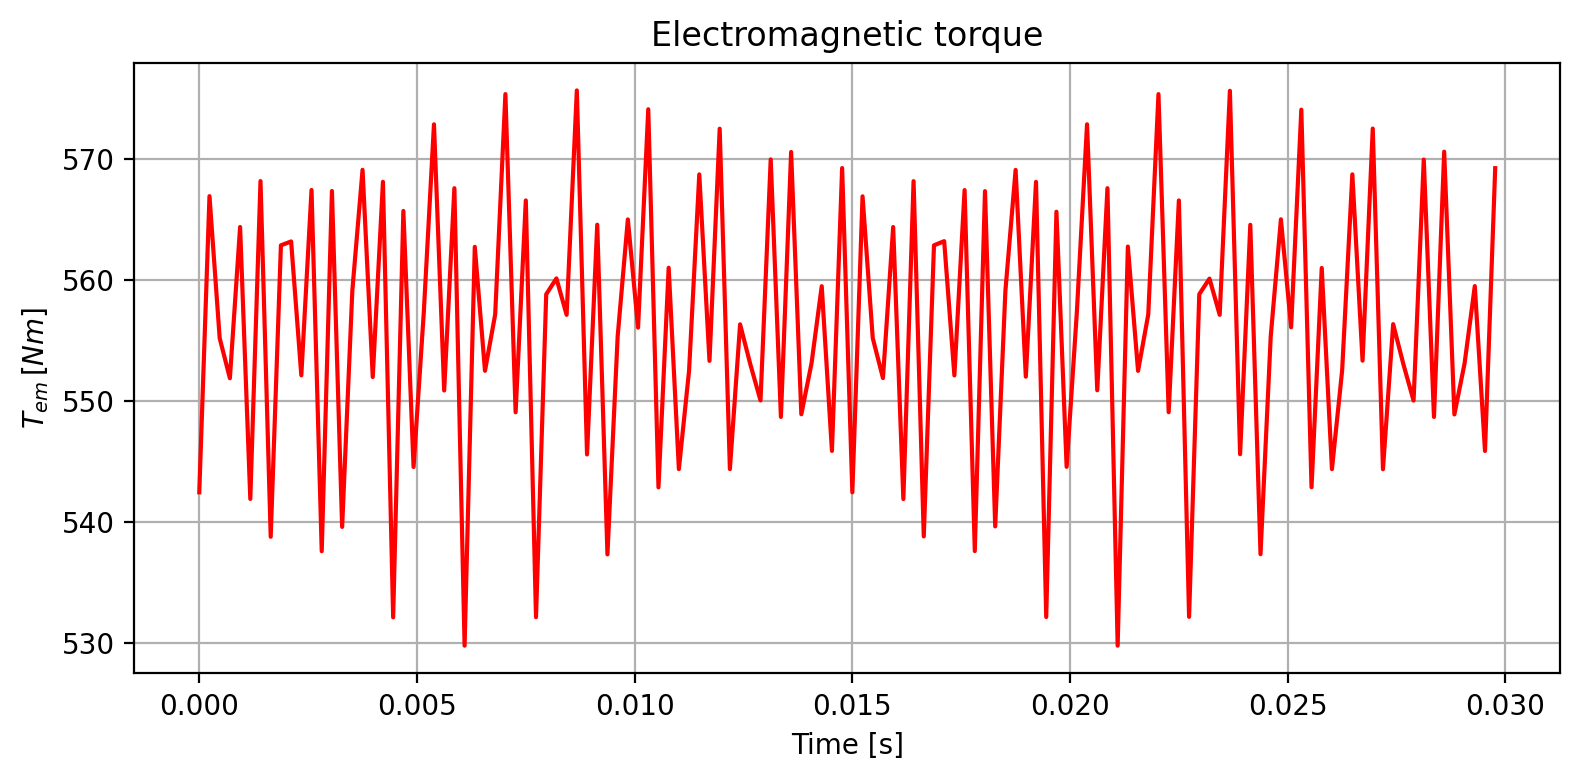

In [33]:
print("\n[GRAPHIQUES - MACHINE EXCENTREE]")

# Flux d'entrefer en fonction de l'angle
out_ecc.mag.B.plot_2D_Data("angle", **dict_2D)

# Couple électromagnétique en fonction du temps
out_ecc.mag.Tem.plot_2D_Data("time", **dict_2D)


In [36]:
from numpy import pi

# === Définition par I0 / Phi0 (au lieu de Id/Iq direct) ===
# Pour la machine de référence
simu_op.input.OP.set_I0_Phi0(I0=I0_rms, Phi0=Phi0)
print("Machine de référence - OPdq :")
print(simu_op.input.OP.get_Id_Iq())

# Pour la machine excentrée
simu_ecc.input.OP.set_I0_Phi0(I0=I0_rms, Phi0=Phi0)
print("\nMachine excentrée - OPdq :")
print(simu_ecc.input.OP.get_Id_Iq())


Machine de référence - OPdq :
{'Id': -135.4188051049254, 'Iq': 113.62986941801093}

Machine excentrée - OPdq :
{'Id': -135.4188051049254, 'Iq': 113.62986941801093}


machine de referance  tesla modele 3

In [37]:
from numpy import linspace, array, pi

# === Nombre de simulations (points de fonctionnement) ===
N_simu = 10  

# Couples de référence 
Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22])

# Variation de l’angle Phi0 entre 60° et 180°
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_simu = Tem_av_ref.size
print("Nombre de points de fonctionnement:", N_simu)
print("Couples de référence:", Tem_av_ref)
print("Angles Phi0 (rad):", Phi0_ref)


Nombre de points de fonctionnement: 13
Couples de référence: [ 79 125 160 192 237 281 319 343 353 332 266 164  22]
Angles Phi0 (rad): [1.04719755 1.22173048 1.3962634  1.57079633 1.74532925 1.91986218
 2.0943951  2.26892803 2.44346095 2.61799388 2.7925268  2.96705973
 3.14159265]


In [38]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent 
from pyleecan.Classes.DataKeeper import DataKeeper
from numpy import zeros, ones

# === 1. COPIE DE LA SIMULATION RÉFÉRENCE ===
simu_vop = simu_op.copy()
simu_vop.mag.import_file = None  # On garde FEMM interne
varload = VarLoadCurrent()
simu_vop.var_simu = varload

simu_vop.elec = None
simu_vop.force = None
simu_vop.struct = None
# === 2. MATRICE DES POINTS DE FONCTIONNEMENT ===
# Dimensions : (N_simu, 4) -> colonnes = [N0, I0, Phi0, Tem]
OP_matrix = zeros((N_simu, 4))

# Vitesse fixe pour tous les OP
OP_matrix[:, 0] = 2000 * ones((N_simu))   # N0 = 2000 rpm

# Courant RMS constant
OP_matrix[:, 1] = I0_rms * ones((N_simu))  # même amplitude RMS

# Balayage des angles de courant
OP_matrix[:, 2] = Phi0_ref                 # valeurs entre 60° et 180°

# Couples de référence (exemple : Yang et al. 2013, à remplacer si besoin)
OP_matrix[:, 3] = Tem_av_ref

print("Operating Point matrix:")
print(OP_matrix)

print("Original Operating point (avant VarLoad):")
print(simu_vop.input.OP.get_I0_Phi0())

# Associer la matrice aux colonnes correspondantes
varload.set_OP_array(OP_matrix, "N0", "I0", "Phi0", "Tem")

# Le premier OP devient le point initial (optimisation Pyleecan)
print("Updated Operating point (après VarLoad):")
print(simu_vop.input.OP.get_I0_Phi0())

# === 3. OPTIMISATION CALCULS ===
varload.is_reuse_femm_file = True   # on réutilise le modèle FEMM

# === 4. DATAKEEPER (sauvegarde des résultats intéressants) ===
I0_dk = DataKeeper(
    name="Stator current rms amplitude",
    symbol="I0",
    unit="Arms",
    keeper="lambda output: output.elec.OP.get_I0_Phi0()['I0']",
)
Phi0_dk = DataKeeper(
    name="Stator current phase",
    symbol="Phi0",
    unit="rad",
    keeper="lambda output: output.elec.OP.get_I0_Phi0()['Phi0']",
)

# Ajouter au VarLoad
varload.datakeeper_list = [I0_dk, Phi0_dk]


Operating Point matrix:
[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [2.00000000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [2.00000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [2.00000000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [2.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]
Original Operating point (avant VarLoad):
{'I0': 176.77669529663686, 'Phi0': 2.443460952792061}
Updated Operating point (après VarLoad):
{'I0': 176.77669529

In [39]:
# === 5. LANCEMENT DE LA SIMULATION VARLOAD ===
print("\n=== Lancement de la simulation VarLoadCurrent (Tesla Model 3) ===")
Xout = simu_vop.run()

print("\nSimulation terminée ")
print("Résultats disponibles dans Xout.xoutput_dict.keys() :")
print(Xout.xoutput_dict.keys())



=== Lancement de la simulation VarLoadCurrent (Tesla Model 3) ===
[17:50:51] Starting running simulation Tesla_ref (machine=Tesla_model_3)
[17:50:52] Computing reference simulation for Variable Load
[17:50:52] Starting Magnetic module
[17:50:52] Solving slice 1 / 2
[17:51:45] Solving time steps: 0%
[17:51:46] Solving time steps: 0%
[17:51:46] Solving time steps: 0%
[17:51:47] Solving time steps: 0%
[18:02:07] Solving time steps: 25%
[18:02:07] Solving time steps: 25%
[18:02:13] Solving time steps: 25%
[18:02:49] Solving time steps: 25%
[18:10:48] Solving time steps: 50%
[18:10:49] Solving time steps: 50%
[18:11:19] Solving time steps: 50%
[18:12:17] Solving time steps: 50%
[18:21:03] Solving time steps: 75%
[18:21:22] Solving time steps: 75%
[18:21:39] Solving time steps: 75%
[18:21:44] Solving time steps: 75%
[18:29:58] Solving time step: 100%
[18:29:58] Solving time step: 100%
[18:30:14] Solving time step: 100%
[18:30:20] Solving time step: 100%
[18:30:20] Solving slice 2 / 2
[18:31

In [53]:
# === 5. LANCEMENT DE LA SIMULATION VARLOAD ===
print("\n=== Lancement de la simulation VarLoadCurrent (Tesla Model 3) ===")

#  conserver tous les sous-résultats individuels
simu_vop.var_simu.is_keep_all_output = True   #  indispensable pour Xout.output_list

# (optionnel mais utile : limiter le nombre de workers)
simu_vop.mag.nb_worker = 2  

# Lancement de la simulation complète
Xout = simu_vop.run()

# === Affichage de résumé ===
print("\nSimulation terminée ")
print(f"Nombre total de points de fonctionnement : {len(Xout.xoutput_dict['Phi0'].result)}")

# Vérification de la sauvegarde des sous-simulations
if hasattr(Xout, "output_list") and len(Xout.output_list) > 0:
    print(f"Nombre de sous-simulations conservées dans Xout.output_list : {len(Xout.output_list)}")
else:
    print(" Aucun sous-résultat sauvegardé — vérifie var_simu.is_keep_all_output = True")

# Liste des variables globales disponibles
print("\nVariables disponibles dans Xout.xoutput_dict.keys() :")
print(Xout.xoutput_dict.keys())



=== Lancement de la simulation VarLoadCurrent (Tesla Model 3) ===
[14:17:18] Starting running simulation Tesla_ref (machine=Tesla_model_3)
[14:17:18] Computing reference simulation for Variable Load
[14:17:18] Starting Magnetic module
[14:17:19] Solving slice 1 / 2
[14:18:14] Solving time steps: 0%
[14:18:14] Solving time steps: 0%
[14:28:59] Solving time steps: 25%
[14:29:02] Solving time steps: 25%
[14:38:36] Solving time steps: 50%
[14:38:48] Solving time steps: 50%
[14:48:13] Solving time steps: 75%
[14:48:29] Solving time steps: 75%
[14:57:20] Solving time step: 100%
[14:57:35] Solving time step: 100%
[14:57:35] Solving slice 2 / 2
[14:58:27] Solving time steps: 0%
[14:58:27] Solving time steps: 0%
[15:08:42] Solving time steps: 25%
[15:08:45] Solving time steps: 25%
[15:22:08] Solving time steps: 50%
[15:22:23] Solving time steps: 50%
[15:33:38] Solving time steps: 75%
[15:33:56] Solving time steps: 75%
[15:46:05] Solving time step: 100%
[15:46:13] Solving time step: 100%
[15:46

In [54]:
# === 6. ANALYSE DES RÉSULTATS VARLOAD ===
print("Values available in XOutput:")
print(Xout.xoutput_dict.keys())
print(varload.OP_matrix.col_names)

print("\nI0 for each simulation:")
print(Xout["I0"].result)
print("\nPhi0 for each simulation:")
print(Xout["Phi0"].result)


Values available in XOutput:
dict_keys(['I0', 'Phi0', 'N0', 'Id', 'Iq', 'Tem_av_ref', 'Tem_av', 'Tem_rip_pp', 'Tem_rip_norm', 'Pem_av'])
['N0', 'Id', 'Iq', 'Tem']

I0 for each simulation:
[176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663683, 176.77669529663686]

Phi0 for each simulation:
[1.0471975511965976, 1.2217304763960306, 1.3962634015954636, 1.5707963267948966, 1.7453292519943295, 1.9198621771937625, 2.0943951023931957, 2.2689280275926285, 2.443460952792061, 2.6179938779914944, 2.7925268031909276, 2.9670597283903604, 3.141592653589793]


In [55]:
print("Clés disponibles dans Xout :")
print(Xout.__dict__.keys())

if hasattr(Xout, "output_list"):
    print(f"\nNombre de sorties enregistrées : {len(Xout.output_list)}")
else:
    print(" Aucun attribut 'output_list' trouvé.")


Clés disponibles dans Xout :
dict_keys(['_paramexplorer_list', '_output_list', '_xoutput_dict', '_nb_simu', '_xoutput_ref', '_xoutput_ref_index', 'parent', '_simu', '_path_result', '_geo', '_elec', '_mag', '_struct', '_post', '_logger_name', '_force', '_loss', '_FrozenClass__isfrozen'])

Nombre de sorties enregistrées : 13



[GRAPHIQUES - VARLOAD TESLA MODEL 3]
Affichage des grandeurs globales (Tem_av, Pem_av, etc.)...



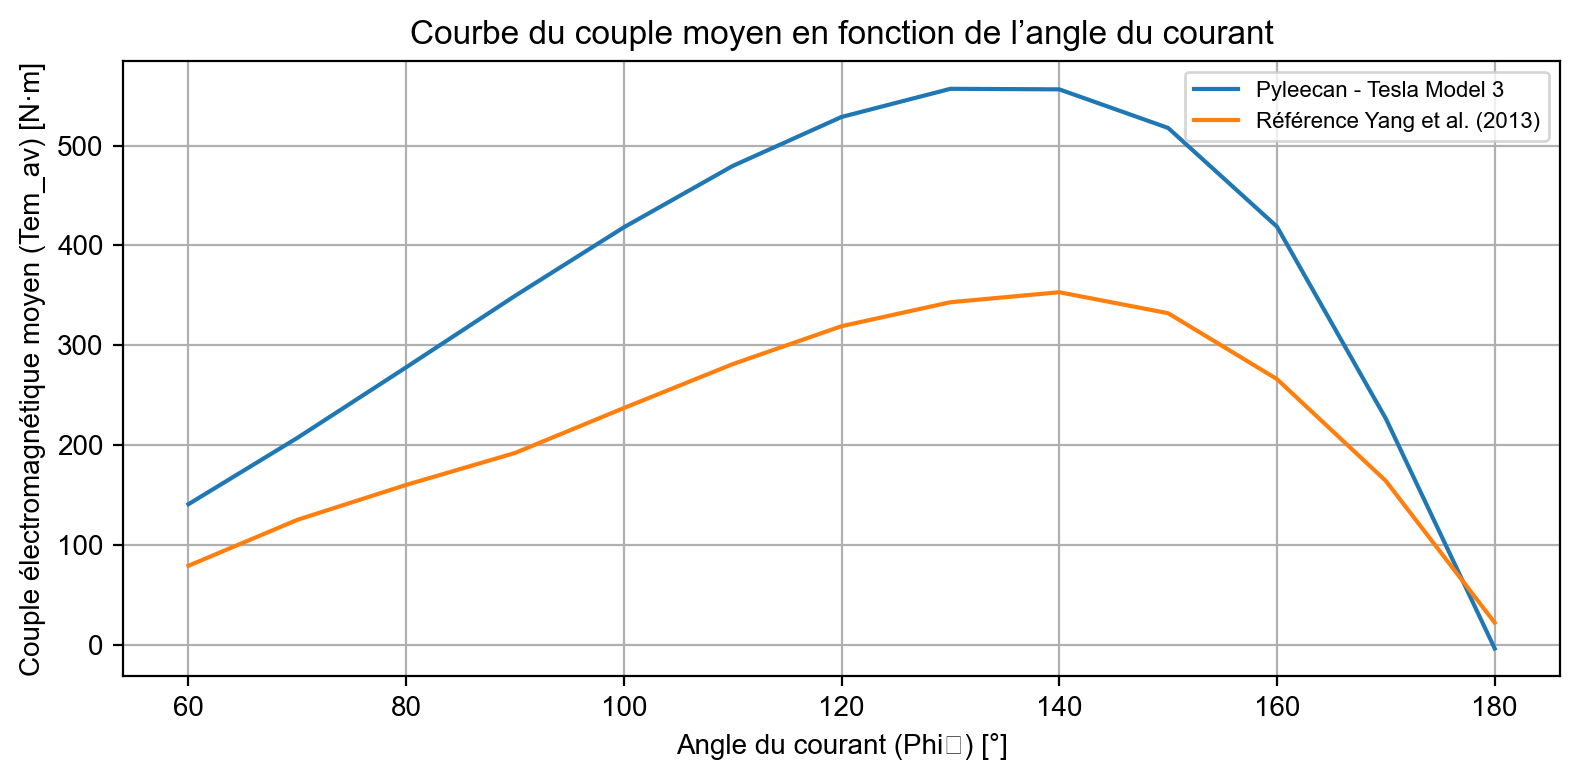

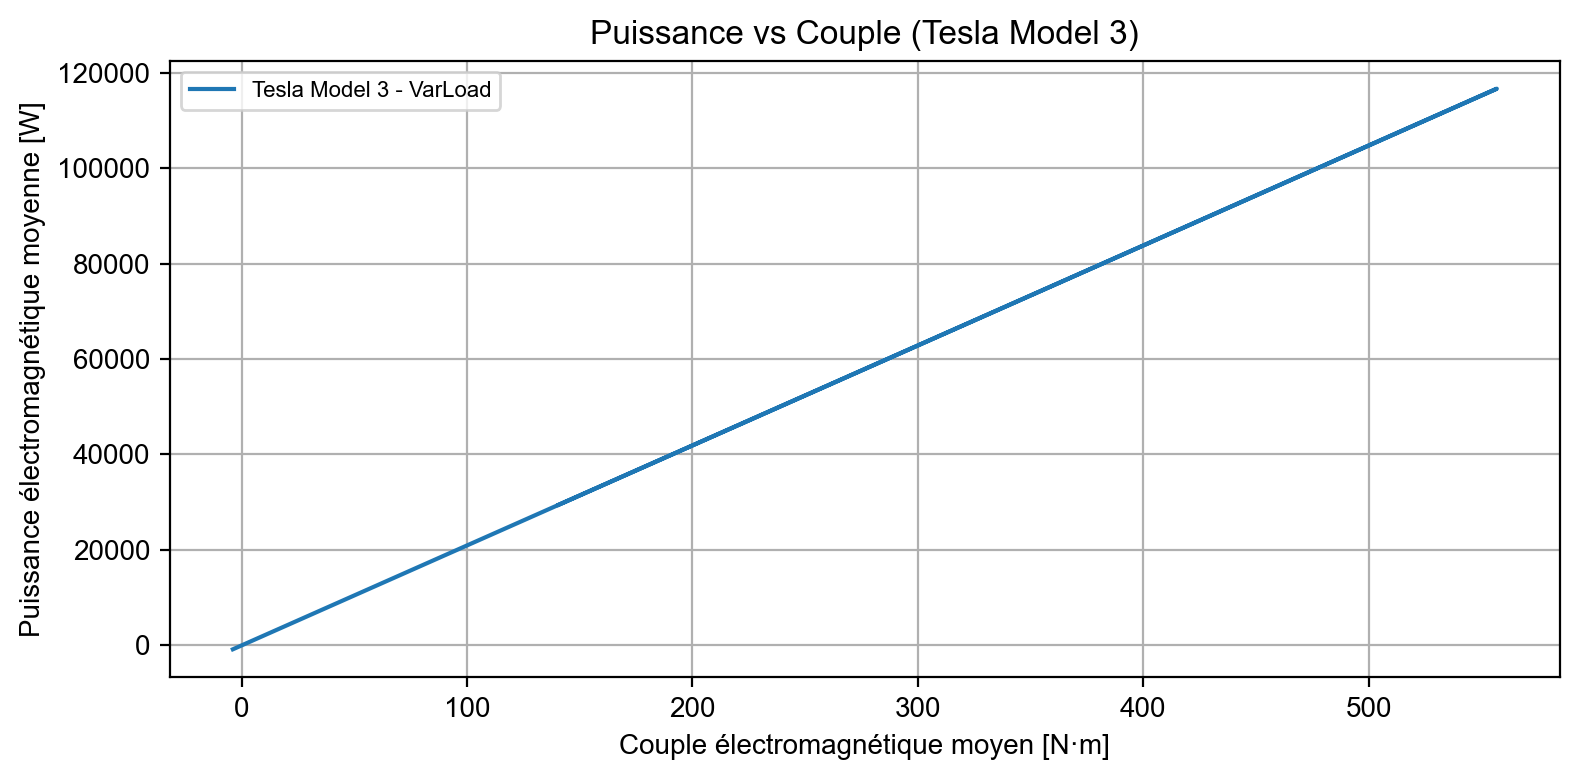

In [56]:
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from numpy import array, pi

print("\n[GRAPHIQUES - VARLOAD TESLA MODEL 3]")
print("Affichage des grandeurs globales (Tem_av, Pem_av, etc.)...\n")

# Récupération des données du XOutput
Phi0_deg = [x * 180 / pi for x in Xout.xoutput_dict["Phi0"].result]
Tem_av = Xout.xoutput_dict["Tem_av"].result
Tem_ref = Xout.xoutput_dict["Tem_av_ref"].result
Pem_av = Xout.xoutput_dict["Pem_av"].result

# ===  COUPLE ÉLECTROMAGNÉTIQUE MOYEN EN FONCTION DE L’ANGLE ===
plot_2D(
    array(Phi0_deg),
    [Tem_av, Tem_ref],
    legend_list=["Pyleecan - Tesla Model 3", "Référence Yang et al. (2013)"],
    xlabel="Angle du courant (Phi₀) [°]",
    ylabel="Couple électromagnétique moyen (Tem_av) [N·m]",
    title="Courbe du couple moyen en fonction de l’angle du courant",
)

# ===  PUISSANCE ÉLECTROMAGNÉTIQUE EN FONCTION DU COUPLE ===
plot_2D(
    array(Tem_av),
    [Pem_av],
    legend_list=["Tesla Model 3 - VarLoad"],
    xlabel="Couple électromagnétique moyen [N·m]",
    ylabel="Puissance électromagnétique moyenne [W]",
    title="Puissance vs Couple (Tesla Model 3)",
)



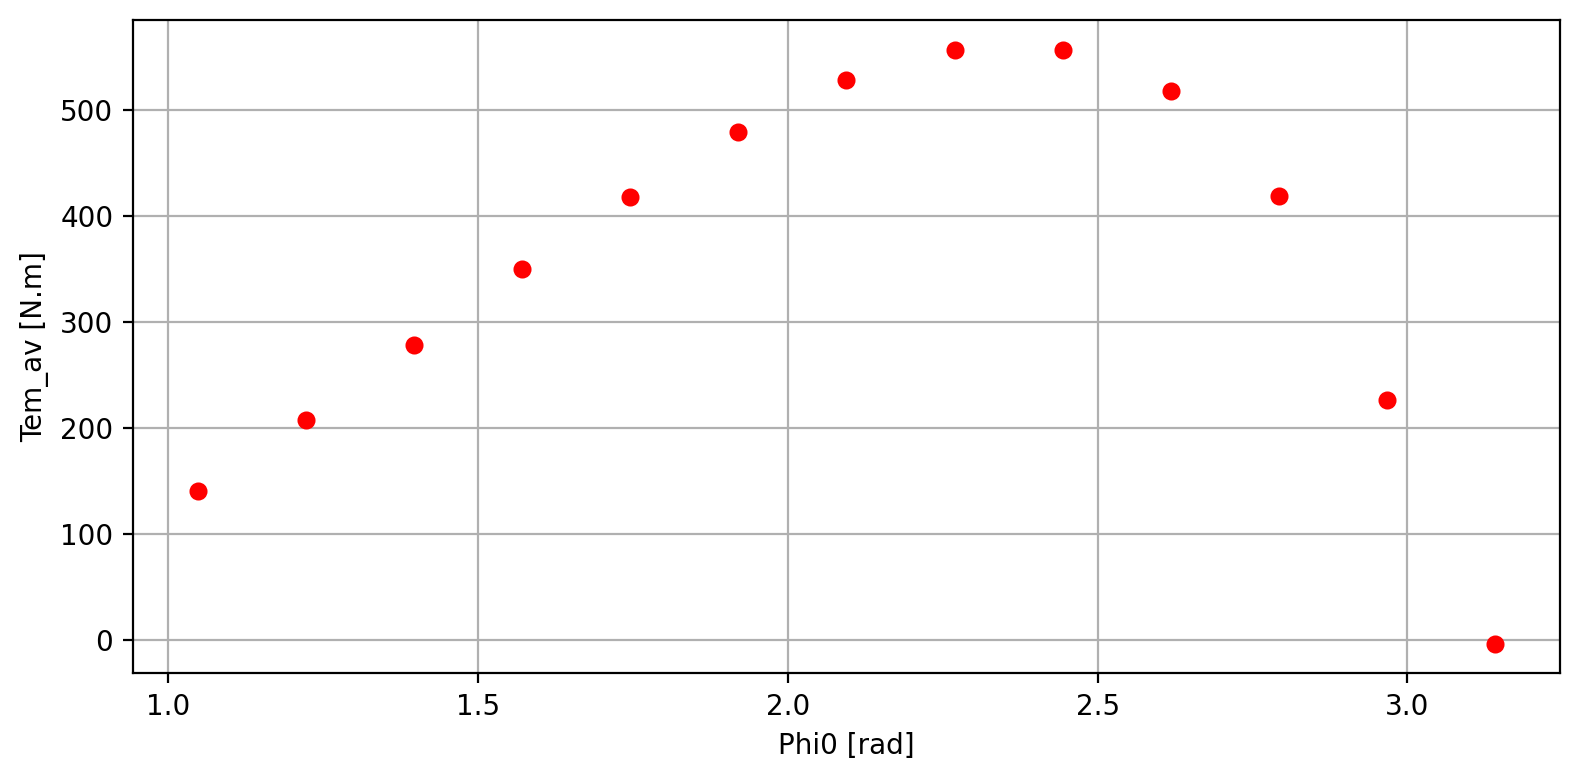

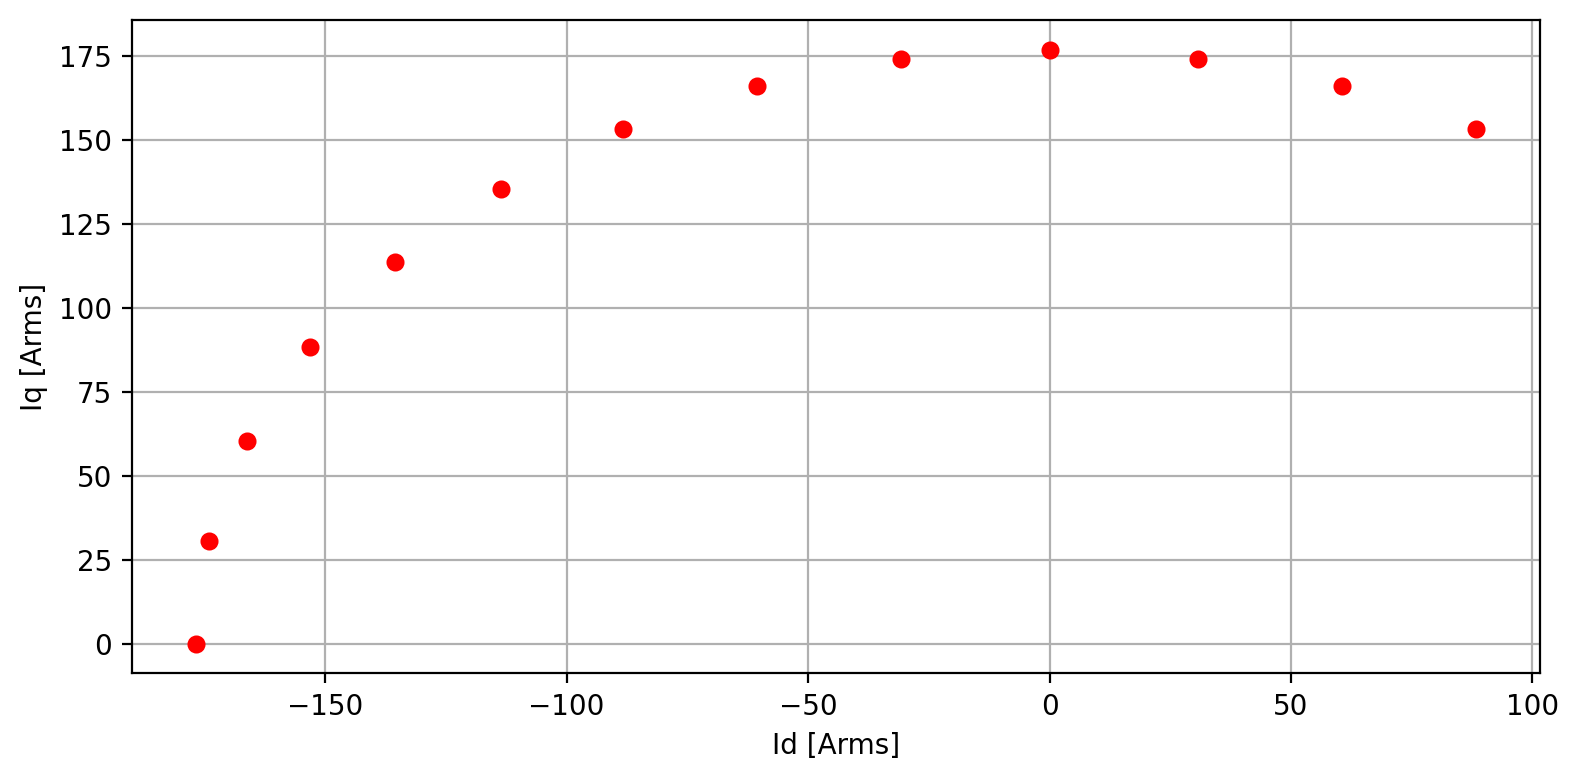

In [57]:
fig_1, ax_1 = Xout.plot_multi("Phi0", "Tem_av")
fig_2, ax_2 = Xout.plot_multi("Id", "Iq")

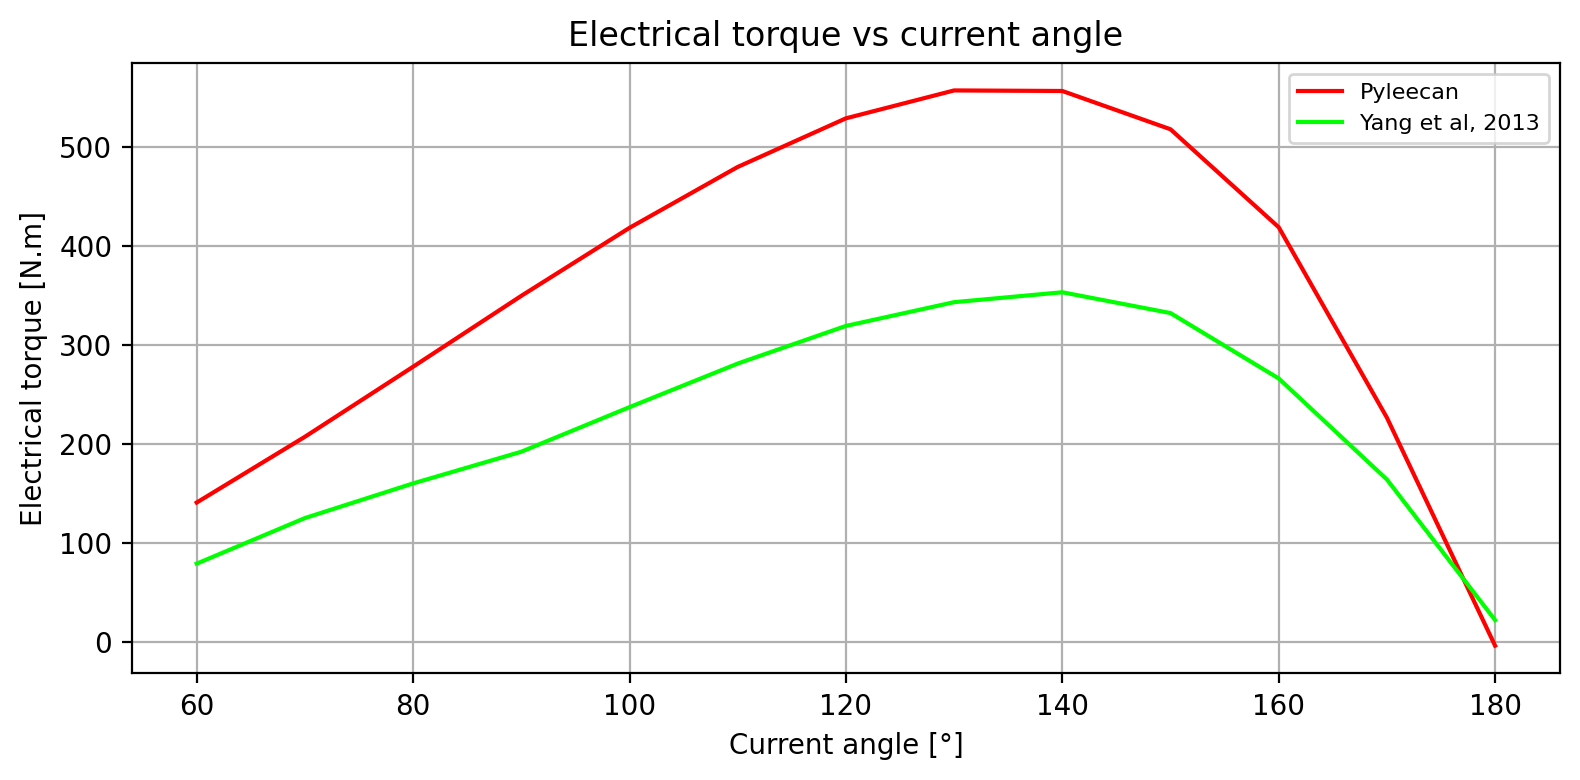

In [58]:
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from pyleecan.definitions import config_dict
from numpy import array

plot_2D(
    array([x*180/pi for x in Xout.xoutput_dict["Phi0"].result]),
    [Xout.xoutput_dict["Tem_av"].result, Xout.xoutput_dict["Tem_av_ref"].result],
    legend_list=["Pyleecan", "Yang et al, 2013"],
    xlabel="Current angle [°]",
    ylabel="Electrical torque [N.m]",
    title="Electrical torque vs current angle",
    **dict_2D
)

In [62]:
%matplotlib inline

from pyleecan.Functions.Plot import dict_2D
import matplotlib.pyplot as plt
import os
import numpy as np

print("\n[GRAPHIQUES - MACHINE TESLA MODEL 3 - VARLOAD]")
print("Affichage et sauvegarde du flux radial, tangentiel et du couple électromagnétique...\n")

# === VÉRIFICATION DES RÉSULTATS VARLOAD ===
if not hasattr(Xout, "output_list") or len(Xout.output_list) == 0:
    print(" Aucun résultat individuel trouvé dans Xout.output_list.")
else:
    n_points = len(Xout.output_list)
    print(f"Nombre total de points de fonctionnement simulés : {n_points}\n")

    # === Dossier de sauvegarde ===
    save_dir = "RESULTATS_VARLOAD_TESLA_MODEL3"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Les graphiques seront enregistrés dans : {save_dir}\n")

    # Pour le graphique global (en fin de boucle)
    Tem_av_list = []
    Phi0_list = []

    # === BOUCLE SUR LES POINTS DE FONCTIONNEMENT ===
    for idx, out_plot in enumerate(Xout.output_list):
        print(f"--- Point de fonctionnement {idx+1}/{n_points} ---")

        point_dir = os.path.join(save_dir, f"Point_{idx+1:02d}")
        os.makedirs(point_dir, exist_ok=True)

        # --- FLUX RADIAL (B_rad) ---
        try:
            print("→ Tracé du flux radial B_rad...")
            out_plot.mag.B.plot_2D_Data(
                "angle",
                data_str="B_rad",
                title=f"Air gap radial flux density - Point {idx+1}",
                **dict_2D
            )
            fig_Br = plt.gcf()
            fig_Br.savefig(os.path.join(point_dir, f"AirGap_Brad_Point{idx+1:02d}.png"))
            plt.close(fig_Br)
        except Exception as e:
            print(f"  Erreur flux radial : {e}")

        # --- FLUX TANGENTIEL (B_tan) ---
        try:
            print("→ Tracé du flux tangentiel B_tan...")
            out_plot.mag.B.plot_2D_Data(
                "angle",
                data_str="B_tan",
                title=f"Air gap circumferential flux density - Point {idx+1}",
                **dict_2D
            )
            fig_Bt = plt.gcf()
            fig_Bt.savefig(os.path.join(point_dir, f"AirGap_Btan_Point{idx+1:02d}.png"))
            plt.close(fig_Bt)
        except Exception as e:
            print(f"  Erreur flux tangentiel : {e}")

        # --- COUPLE ÉLECTROMAGNÉTIQUE (Tem) ---
        try:
            print("→ Tracé du couple électromagnétique...")
            out_plot.mag.Tem.plot_2D_Data(
                "time",
                title=f"Electromagnetic torque - Point {idx+1}",
                **dict_2D
            )
            fig_Tem = plt.gcf()
            fig_Tem.savefig(os.path.join(point_dir, f"Torque_Point{idx+1:02d}.png"))
            plt.close(fig_Tem)

            # Extraction du couple moyen
            Tem_av = out_plot.mag.Tem_av if hasattr(out_plot.mag, "Tem_av") else np.mean(out_plot.mag.Tem.result)
            Tem_av_list.append(Tem_av)
            if hasattr(out_plot, "elec") and hasattr(out_plot.elec.OP, "Phi0"):
                Phi0_list.append(out_plot.elec.OP.Phi0)
        except Exception as e:
            print(f"  Erreur couple électromagnétique : {e}")

        print(f"   Graphiques sauvegardés dans : {point_dir}\n")

    # === GRAPHIQUE GLOBAL : COUPLE MOYEN vs ANGLE DU COURANT ===
    try:
        if len(Phi0_list) > 0 and len(Tem_av_list) > 0:
            plt.figure(figsize=(7, 4))
            plt.plot(np.array(Phi0_list) * 180 / np.pi, Tem_av_list, "r-o", linewidth=2)
            plt.xlabel("Current angle Φ₀ [°]")
            plt.ylabel("Average torque Tₘₐᵥ [N.m]")
            plt.title("Average electromagnetic torque vs current angle Φ₀")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, "Average_Torque_vs_Phi0.png"))
            plt.close()
            print(" Graphique global sauvegardé : Average_Torque_vs_Phi0.png")
    except Exception as e:
        print(f" Erreur lors du tracé du couple moyen : {e}")

    print(f"\n=== Fin de l’affichage et de la sauvegarde ({n_points} points traités) ===")




[GRAPHIQUES - MACHINE TESLA MODEL 3 - VARLOAD]
Affichage et sauvegarde du flux radial, tangentiel et du couple électromagnétique...

Nombre total de points de fonctionnement simulés : 13

Les graphiques seront enregistrés dans : RESULTATS_VARLOAD_TESLA_MODEL3

--- Point de fonctionnement 1/13 ---
→ Tracé du flux radial B_rad...
  Erreur flux radial : plot_2D_Data() got an unexpected keyword argument 'data_str'
→ Tracé du flux tangentiel B_tan...
  Erreur flux tangentiel : plot_2D_Data() got an unexpected keyword argument 'data_str'
→ Tracé du couple électromagnétique...
   Graphiques sauvegardés dans : RESULTATS_VARLOAD_TESLA_MODEL3\Point_01

--- Point de fonctionnement 2/13 ---
→ Tracé du flux radial B_rad...
  Erreur flux radial : plot_2D_Data() got an unexpected keyword argument 'data_str'
→ Tracé du flux tangentiel B_tan...
  Erreur flux tangentiel : plot_2D_Data() got an unexpected keyword argument 'data_str'
→ Tracé du couple électromagnétique...
   Graphiques sauvegardés dans :


[GRAPHIQUES - MACHINE TESLA MODEL 3 - VARLOAD]
Affichage et sauvegarde du flux d’entrefer et du couple électromagnétique...

Nombre total de points de fonctionnement simulés : 13

Les graphiques seront enregistrés dans : RESULTATS_VARLOAD_TESLA_MODEL3

--- Point de fonctionnement 1/13 ---
→ Tracé du flux d’entrefer (B_rad et B_tan)...
→ Tracé du couple électromagnétique instantané...
  Graphiques sauvegardés dans : RESULTATS_VARLOAD_TESLA_MODEL3\Point_01

--- Point de fonctionnement 2/13 ---
→ Tracé du flux d’entrefer (B_rad et B_tan)...
→ Tracé du couple électromagnétique instantané...
  Graphiques sauvegardés dans : RESULTATS_VARLOAD_TESLA_MODEL3\Point_02

--- Point de fonctionnement 3/13 ---
→ Tracé du flux d’entrefer (B_rad et B_tan)...
→ Tracé du couple électromagnétique instantané...
  Graphiques sauvegardés dans : RESULTATS_VARLOAD_TESLA_MODEL3\Point_03

--- Point de fonctionnement 4/13 ---
→ Tracé du flux d’entrefer (B_rad et B_tan)...
→ Tracé du couple électromagnétique insta

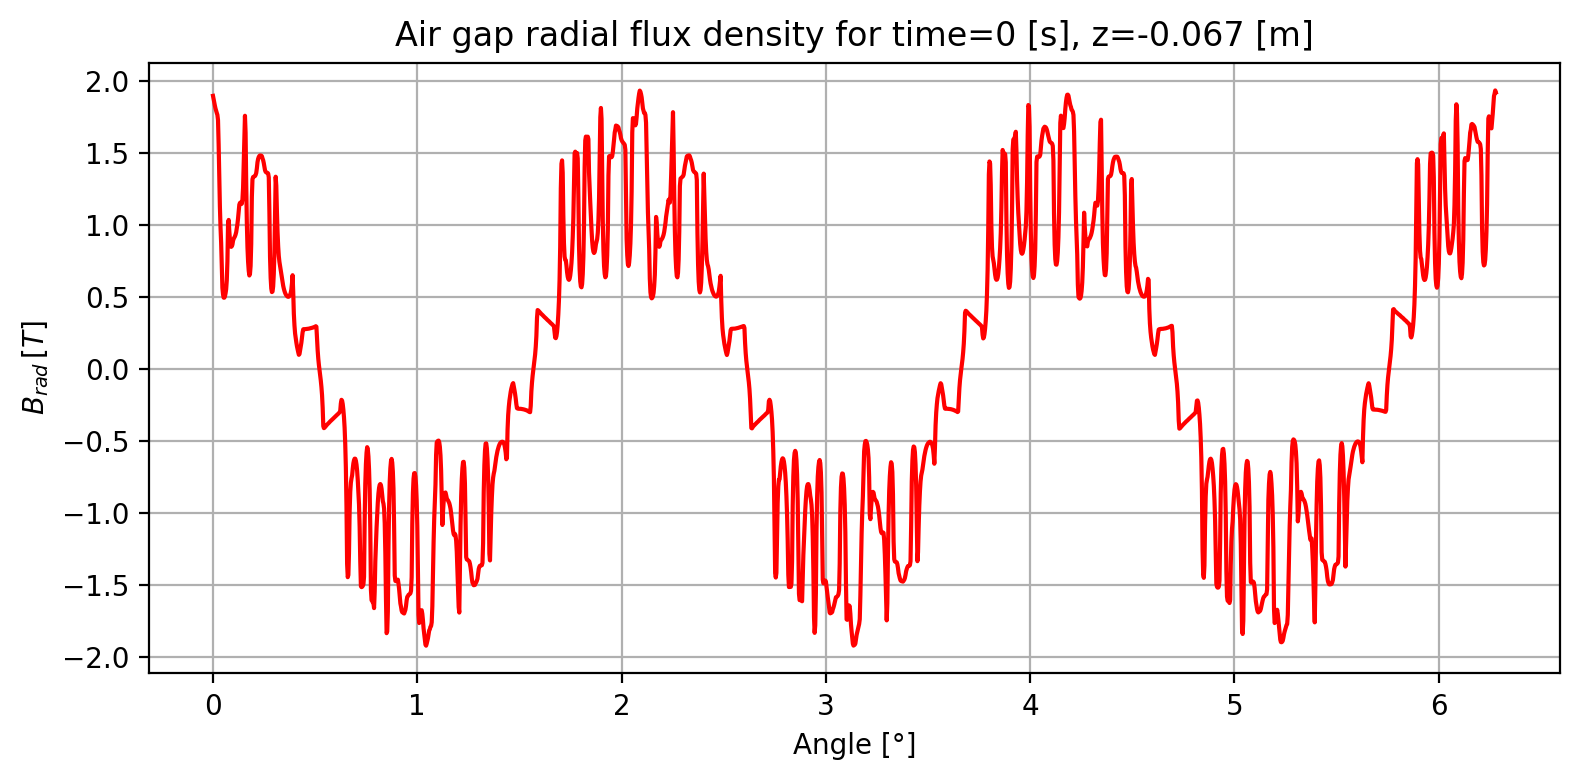

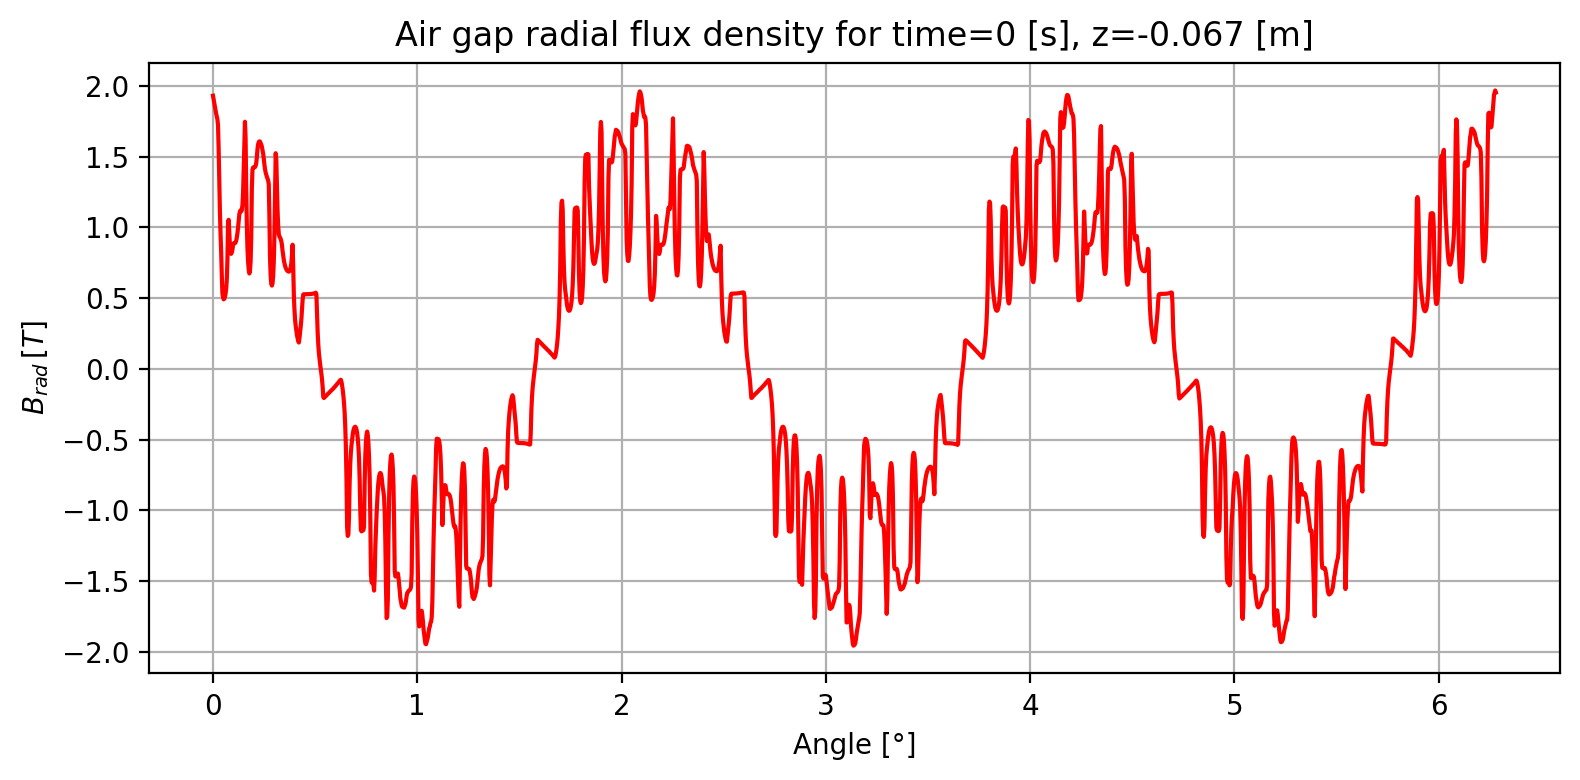

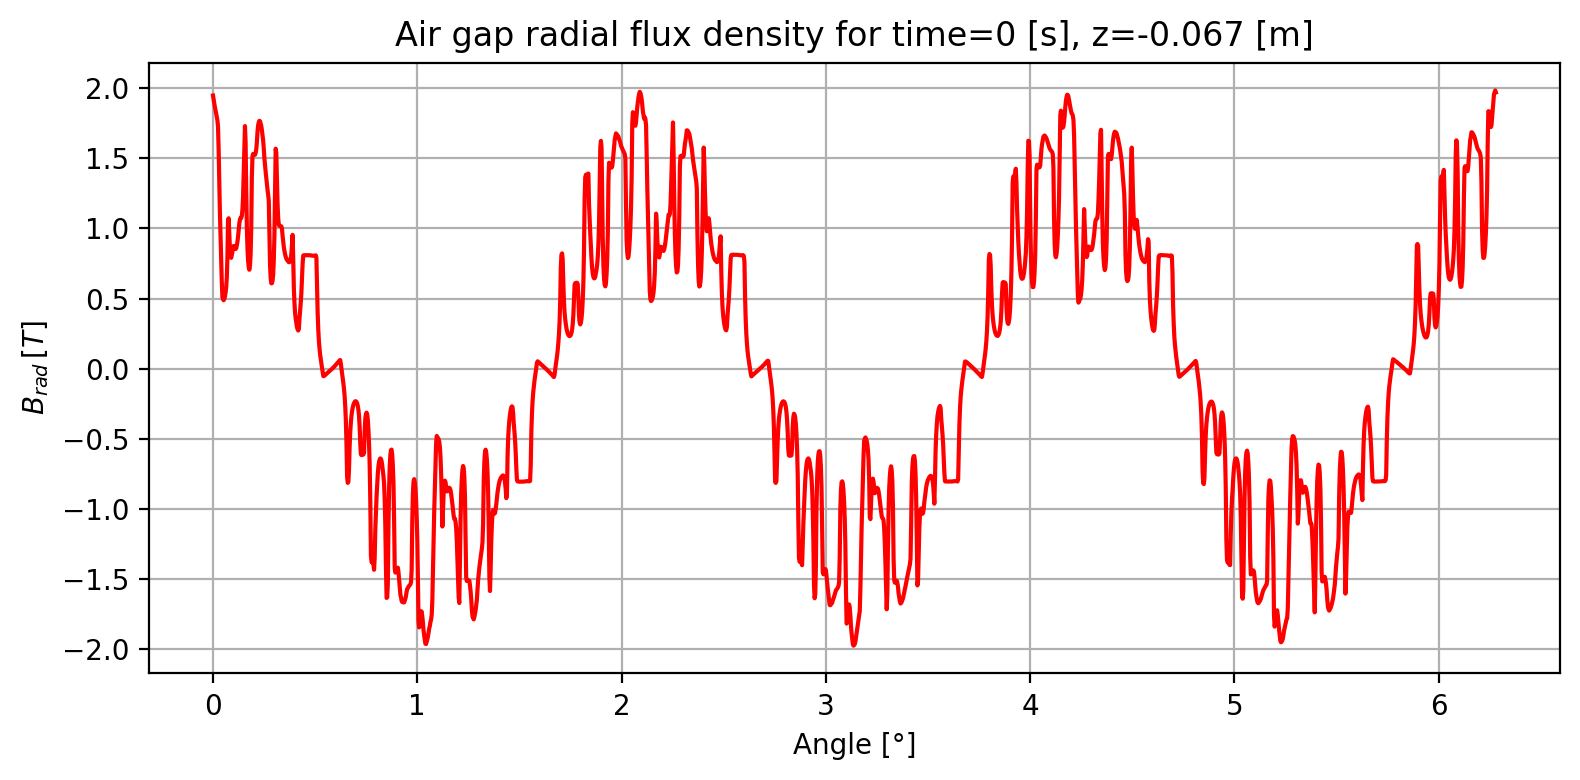

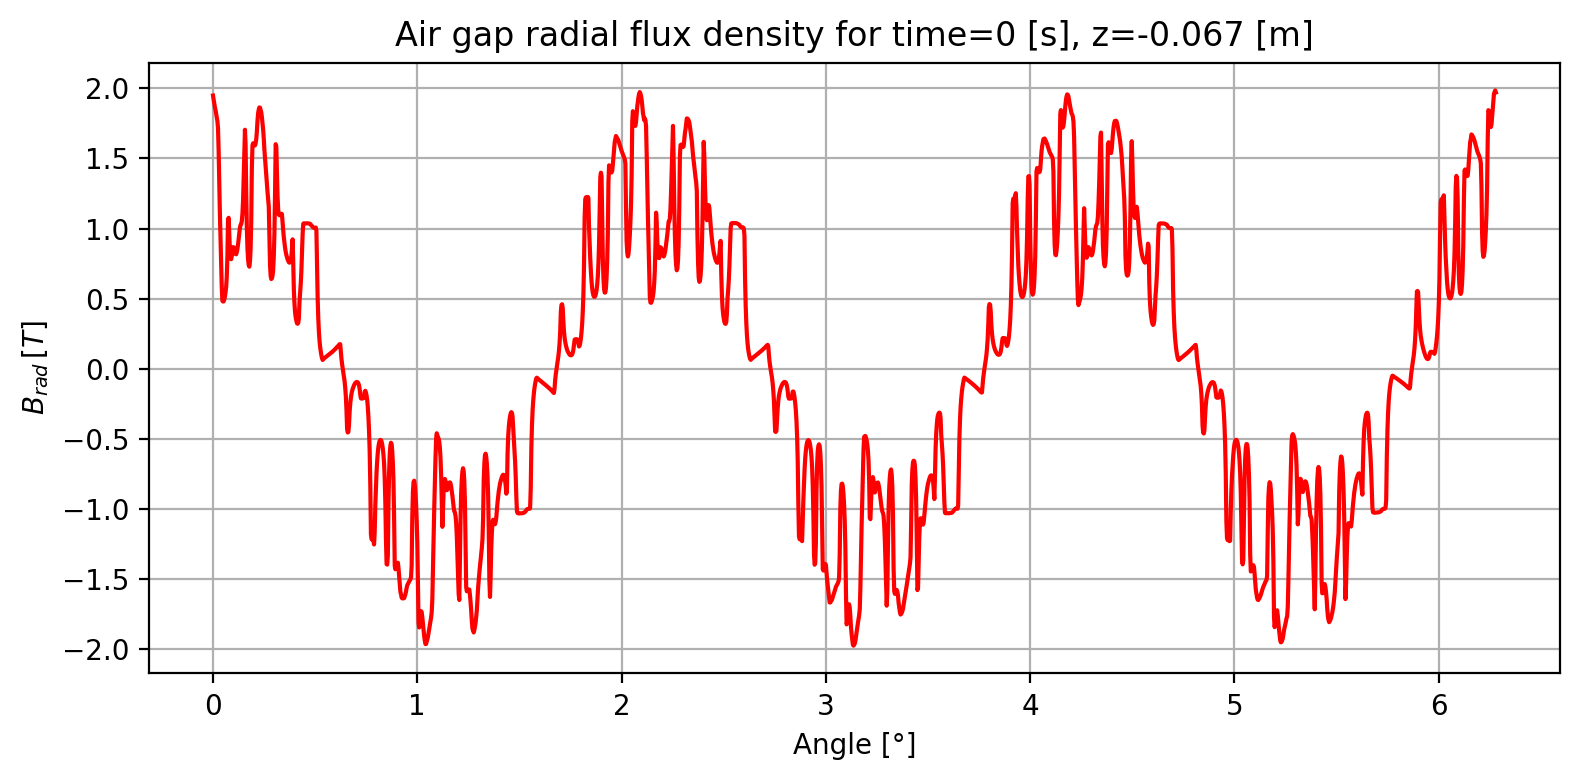

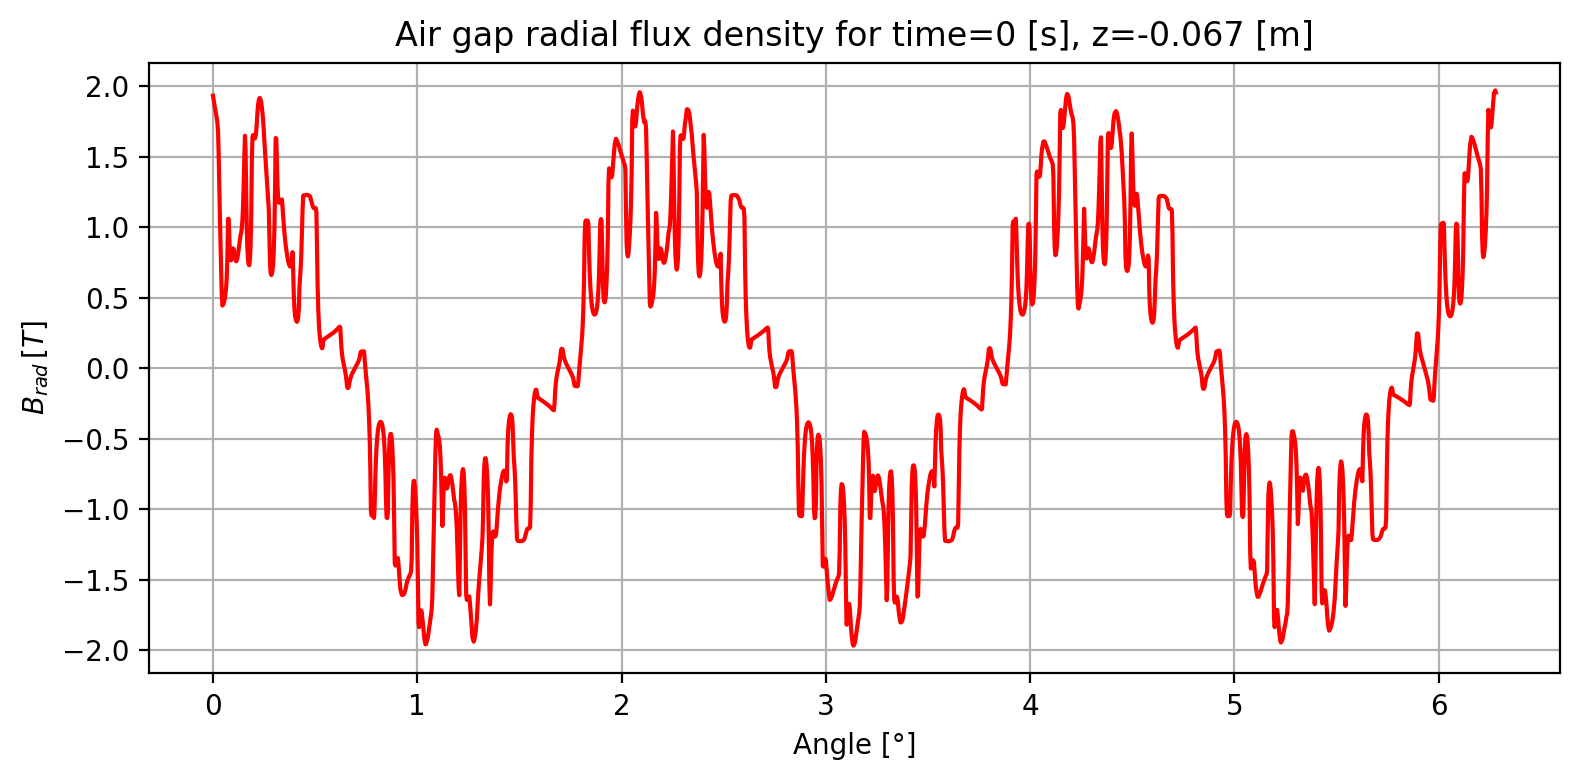

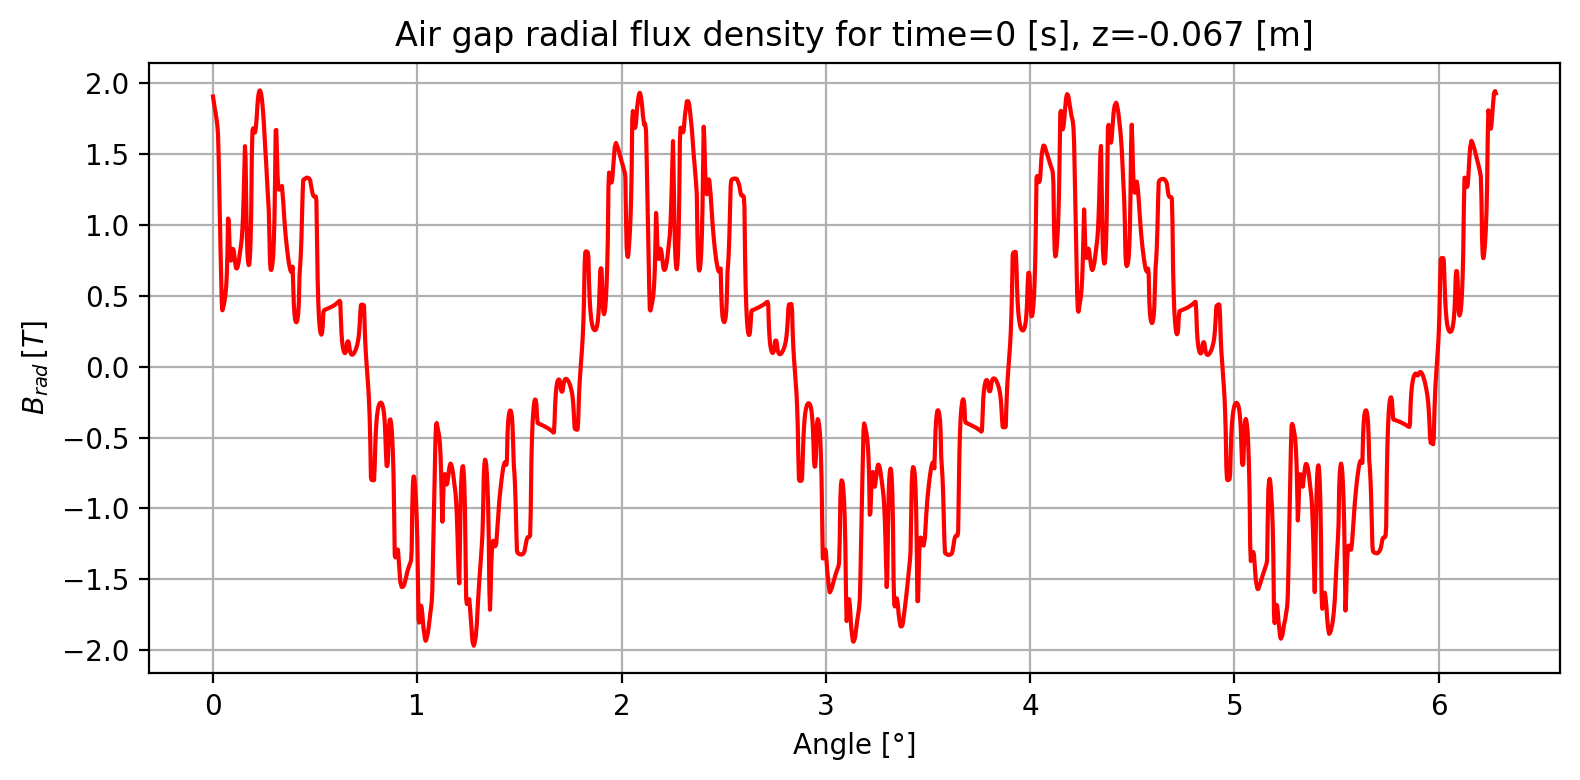

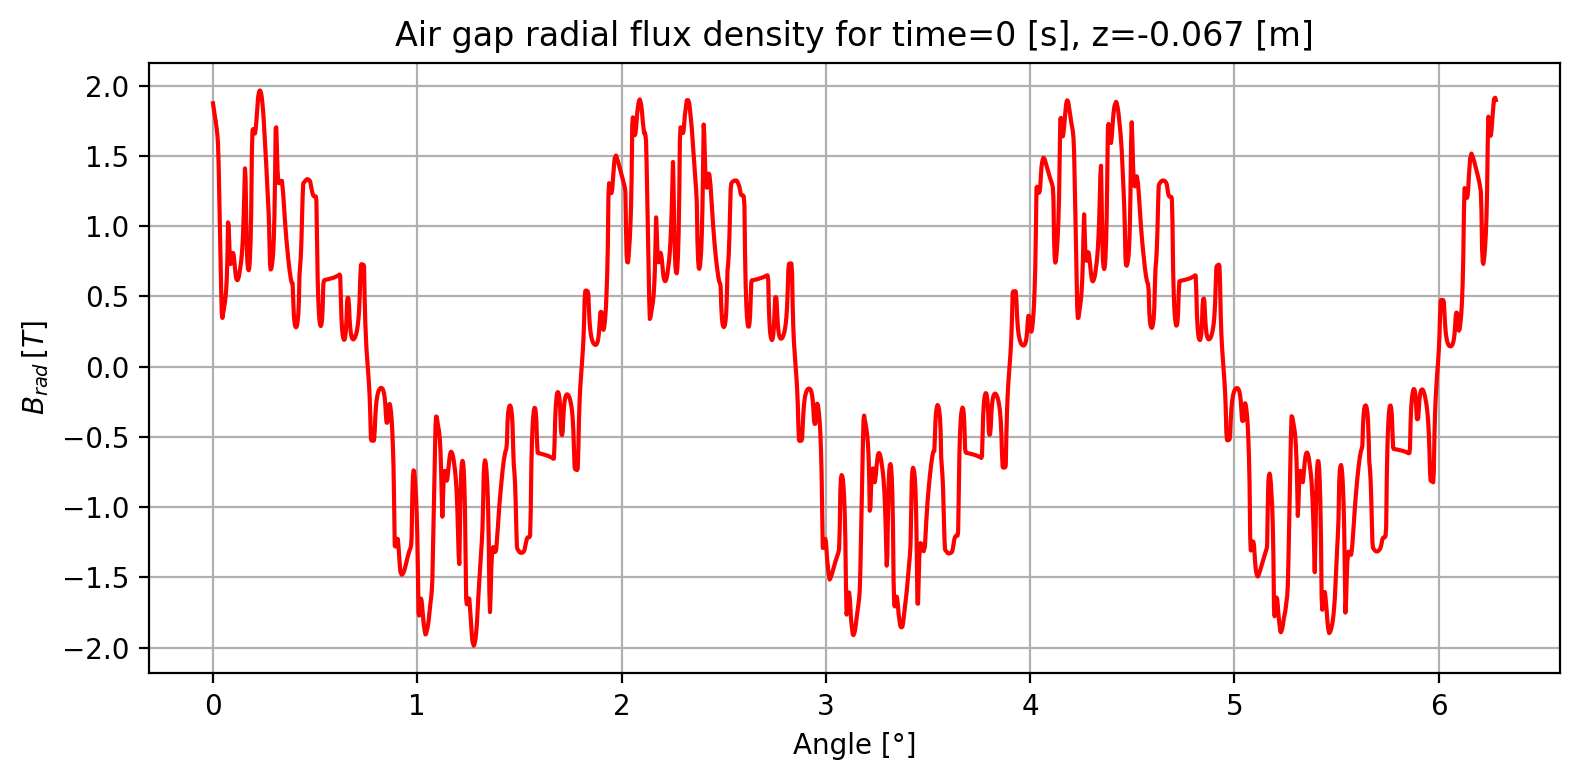

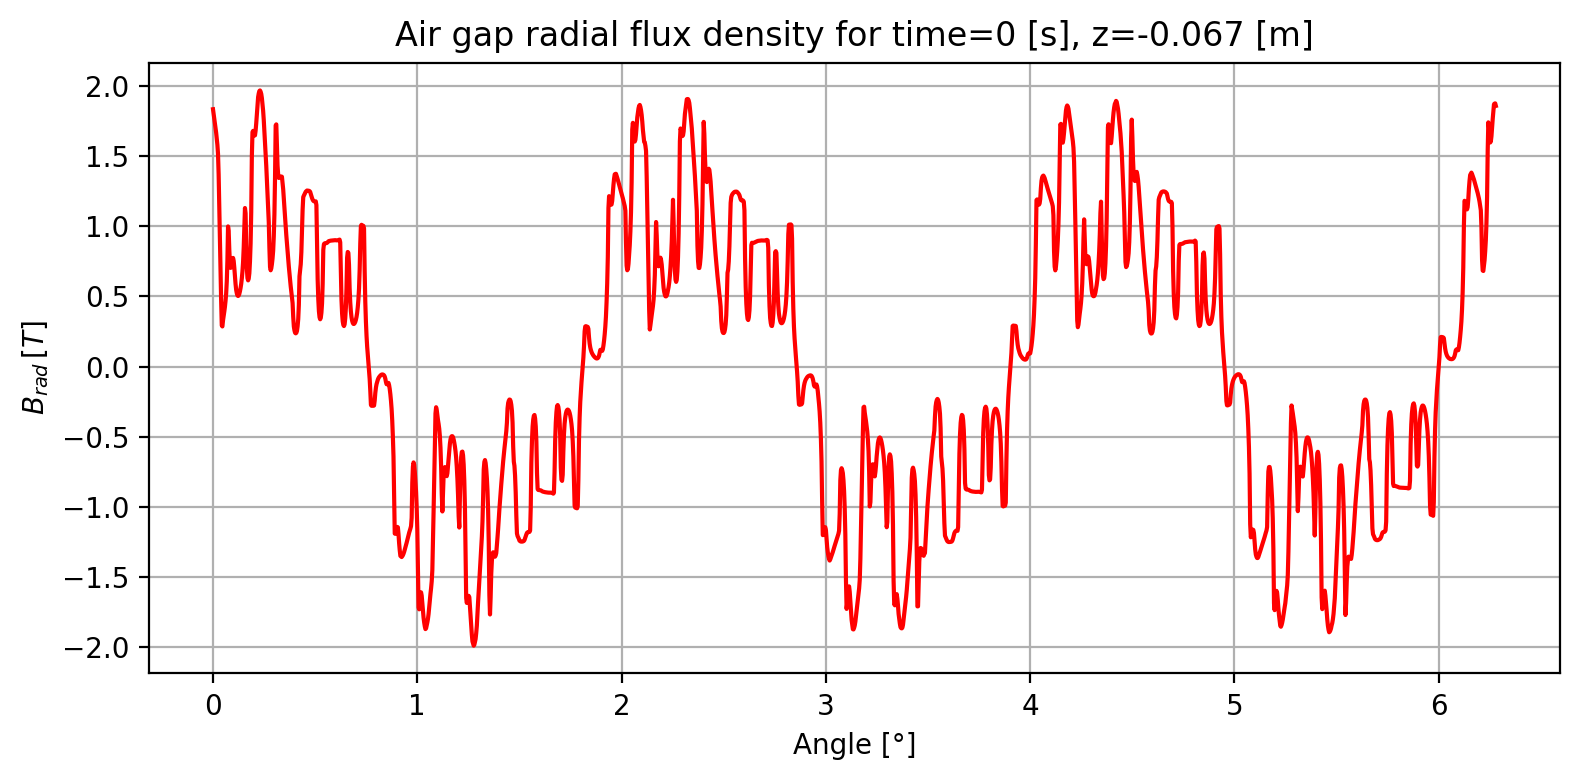

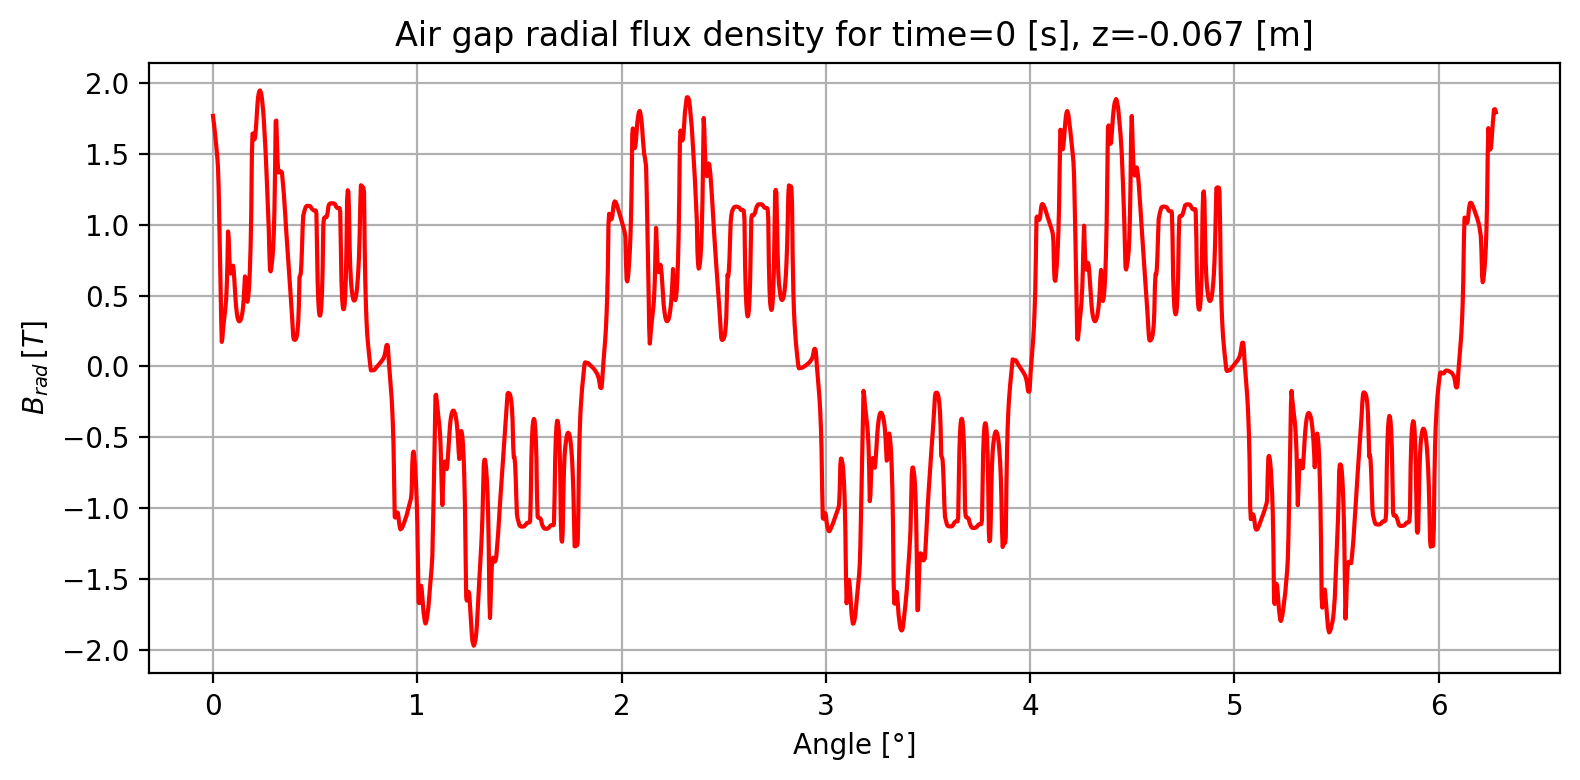

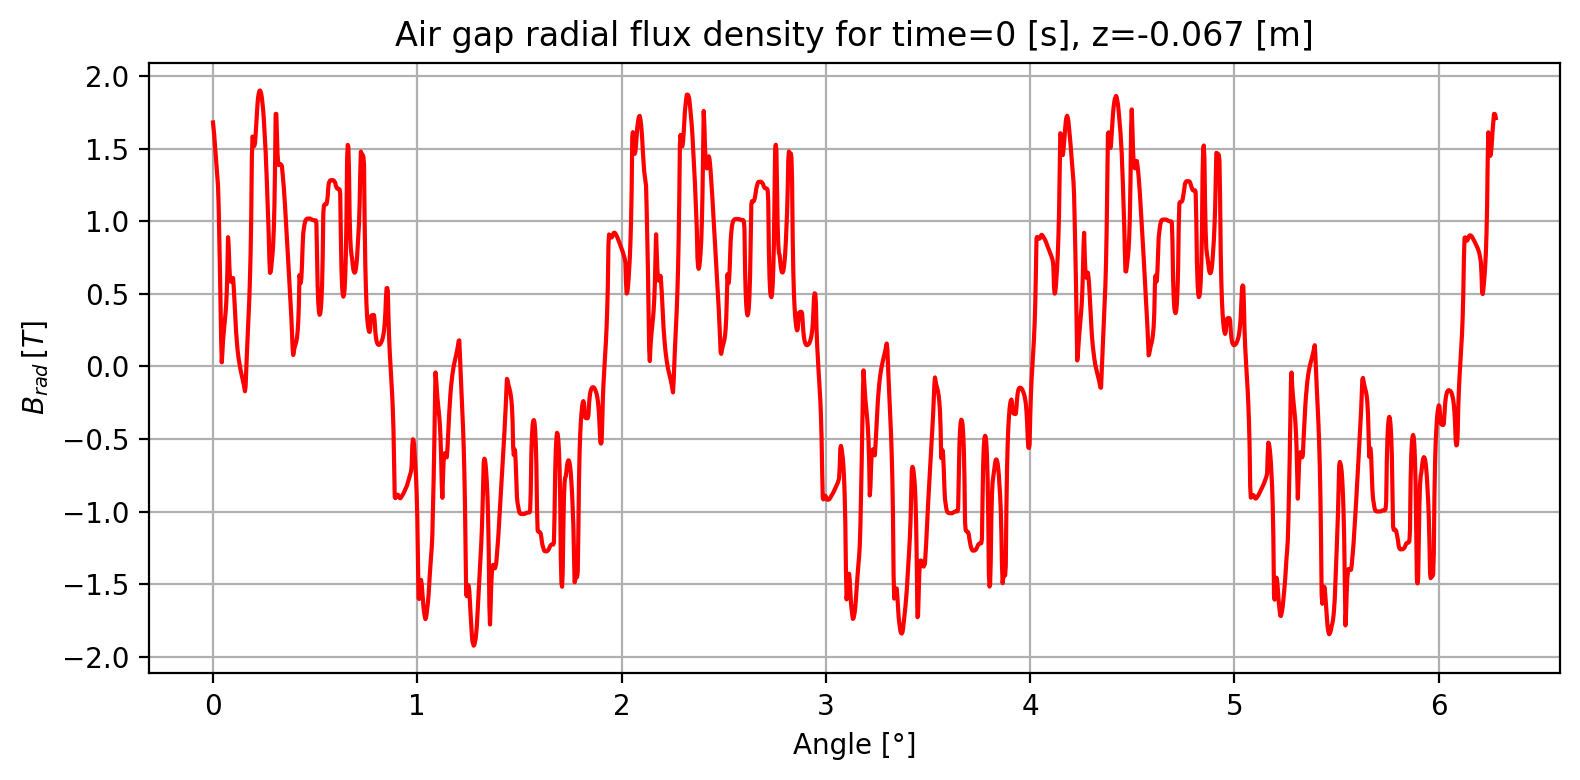

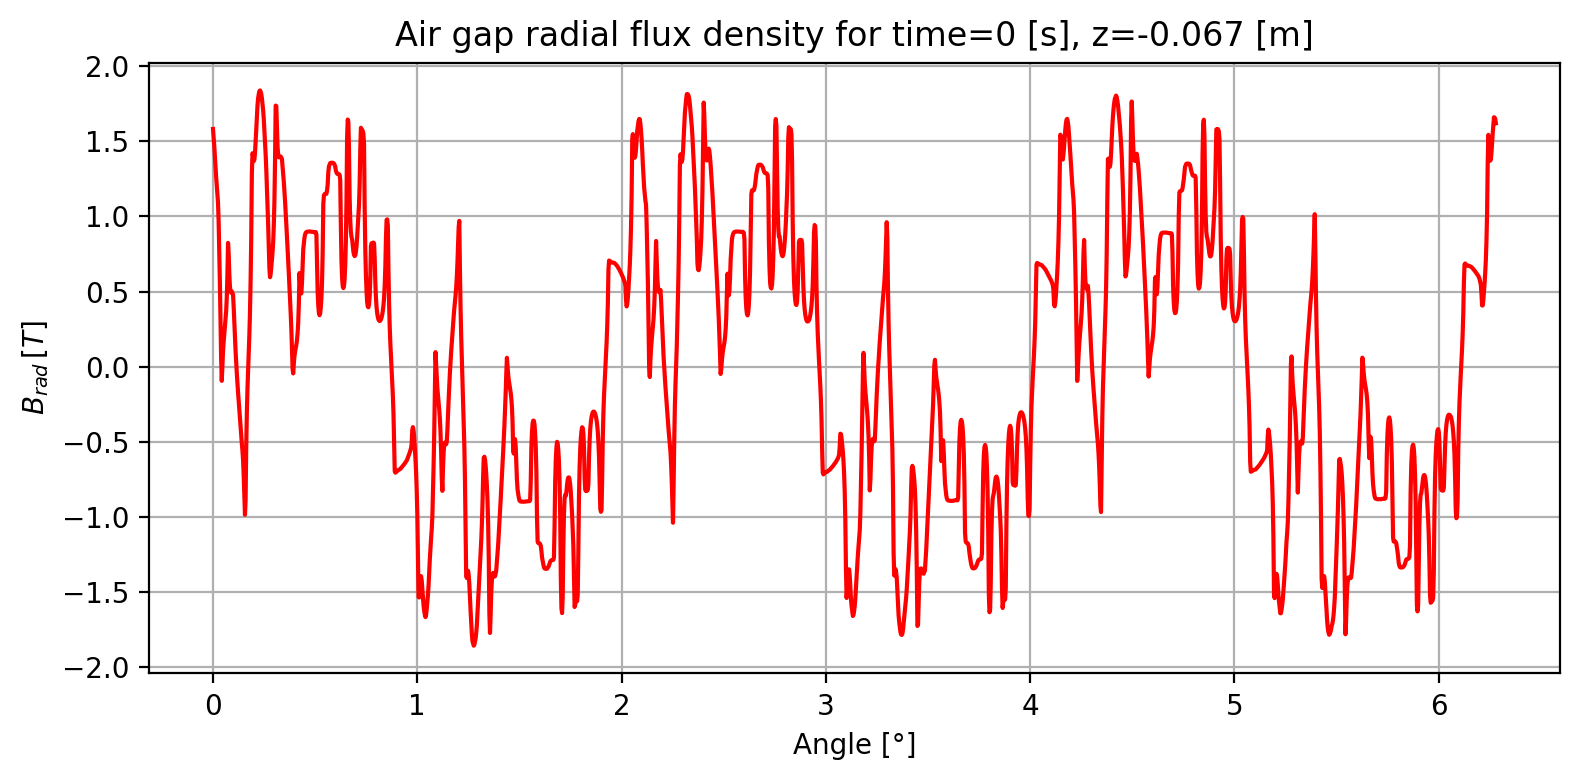

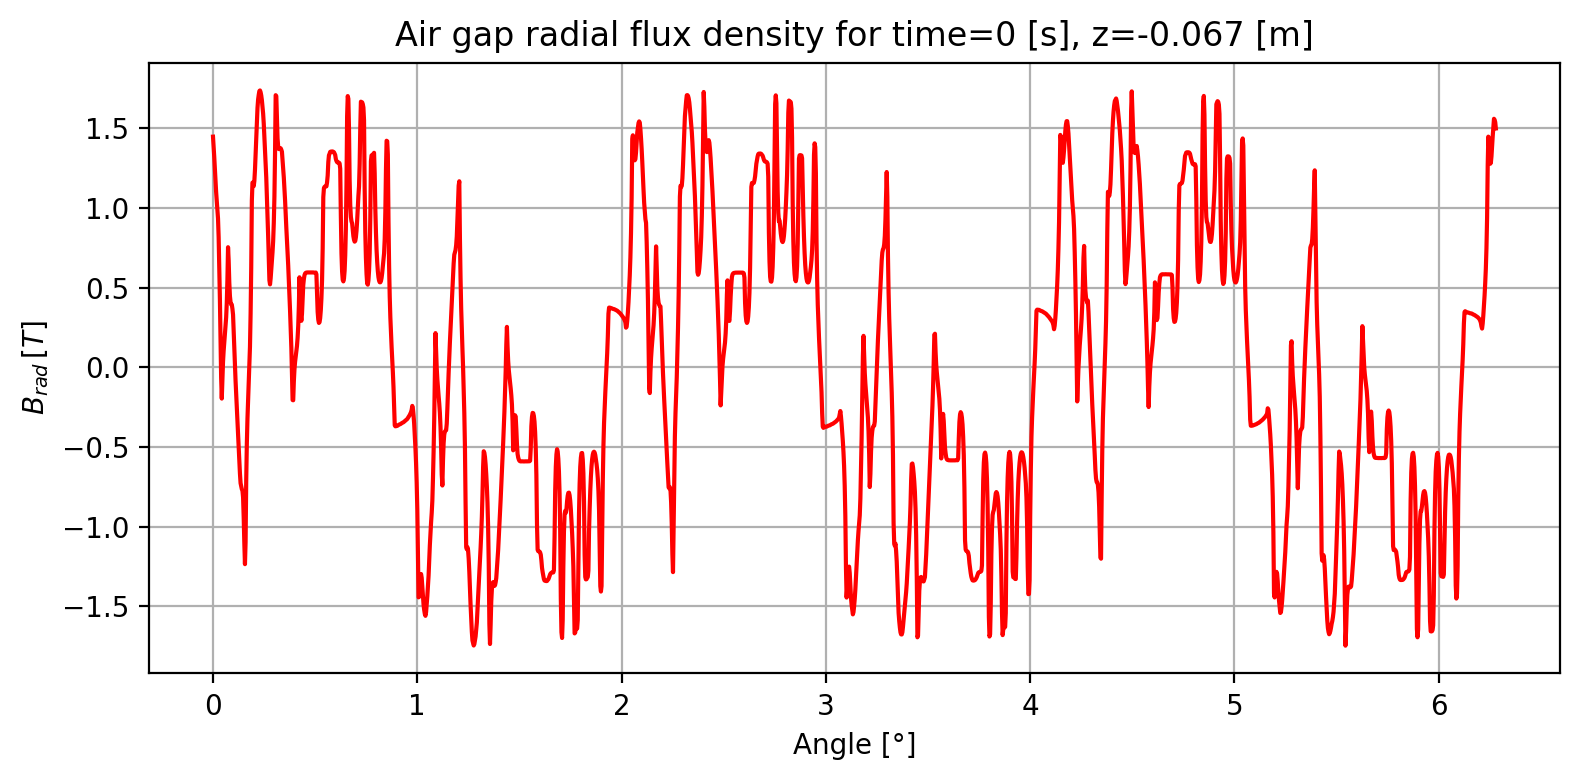

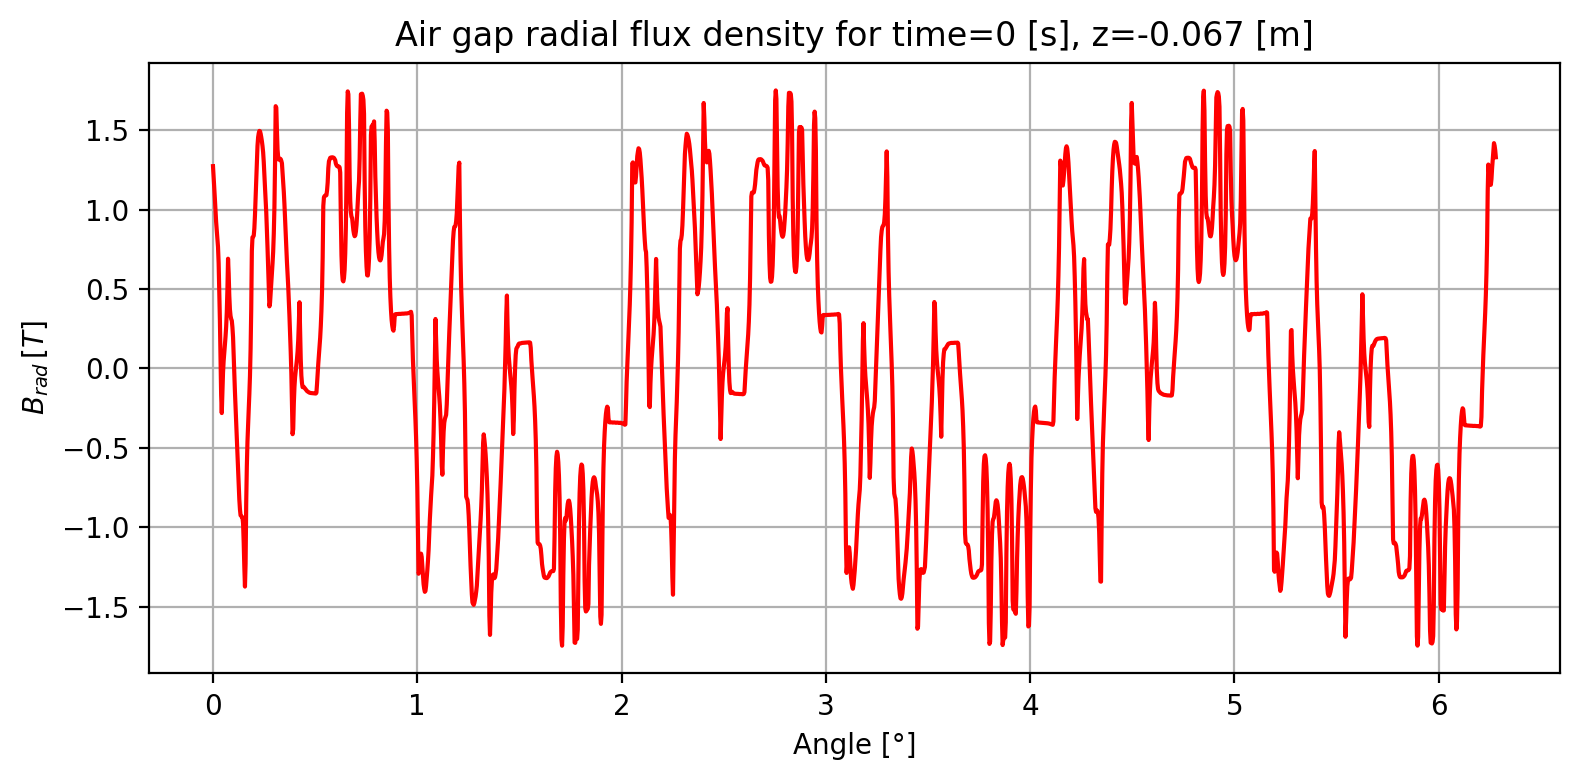

In [61]:
%matplotlib inline
from pyleecan.Functions.Plot import dict_2D
import matplotlib.pyplot as plt
import os
import numpy as np

print("\n[GRAPHIQUES - MACHINE TESLA MODEL 3 - VARLOAD]")
print("Affichage et sauvegarde du flux d’entrefer et du couple électromagnétique...\n")

# === VÉRIFICATION DES RÉSULTATS VARLOAD ===
if not hasattr(Xout, "output_list") or len(Xout.output_list) == 0:
    print(" Aucun résultat individuel trouvé dans Xout.output_list.")
else:
    n_points = len(Xout.output_list)
    print(f"Nombre total de points de fonctionnement simulés : {n_points}\n")

    # === Dossier de sauvegarde ===
    save_dir = "RESULTATS_VARLOAD_TESLA_MODEL3"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Les graphiques seront enregistrés dans : {save_dir}\n")

    # Liste pour stocker les couples moyens (Tem_av)
    Tem_av_list = []
    Phi0_list = []
    Id_list, Iq_list = [], []

    # === BOUCLE SUR TOUS LES POINTS DE FONCTIONNEMENT ===
    for idx, out_plot in enumerate(Xout.output_list):
        print(f"--- Point de fonctionnement {idx+1}/{n_points} ---")

        # Sous-dossier pour chaque point
        point_dir = os.path.join(save_dir, f"Point_{idx+1:02d}")
        os.makedirs(point_dir, exist_ok=True)

        # === FLUX D’ENTREFER ===
        if hasattr(out_plot.mag, "B") and out_plot.mag.B is not None:
            print("→ Tracé du flux d’entrefer (B_rad et B_tan)...")
            try:
                res = out_plot.mag.B.plot_2D_Data("angle", **dict_2D)
                fig_B = plt.gcf()
                fig_B.suptitle(f"Flux d’entrefer - Point {idx+1}", fontsize=12)
                fig_B.savefig(os.path.join(point_dir, f"Flux_Entrefer_Point{idx+1:02d}.png"))
                plt.close(fig_B)
            except Exception as e:
                print(f"  Erreur lors du tracé du flux : {e}")
        else:
            print("   Données de flux non disponibles pour ce point.")

        # === COUPLE ÉLECTROMAGNÉTIQUE INSTANTANÉ ===
        if hasattr(out_plot.mag, "Tem") and out_plot.mag.Tem is not None:
            print("→ Tracé du couple électromagnétique instantané...")
            try:
                res = out_plot.mag.Tem.plot_2D_Data("time", **dict_2D)
                fig_Tem = plt.gcf()
                fig_Tem.suptitle(f"Couple électromagnétique - Point {idx+1}", fontsize=12)
                fig_Tem.savefig(os.path.join(point_dir, f"Couple_Point{idx+1:02d}.png"))
                plt.close(fig_Tem)
            except Exception as e:
                print(f"  Erreur lors du tracé du couple : {e}")
        else:
            print("   Données de couple non disponibles pour ce point.")

        # === EXTRACTION DES VALEURS MOYENNES ===
        try:
            Tem_av = out_plot.mag.Tem_av if hasattr(out_plot.mag, "Tem_av") else np.mean(out_plot.mag.Tem.result)
            Tem_av_list.append(Tem_av)
            Phi0_list.append(out_plot.elec.OP.get_I0_Phi0()['Phi0'] if hasattr(out_plot, 'elec') else None)
            Id_list.append(out_plot.elec.OP.Id_ref if hasattr(out_plot, 'elec') else None)
            Iq_list.append(out_plot.elec.OP.Iq_ref if hasattr(out_plot, 'elec') else None)
        except Exception as e:
            print(f"  Impossible d’extraire les données de ce point : {e}")

        print(f"  Graphiques sauvegardés dans : {point_dir}\n")

    # === GRAPHIQUE GLOBAL : COUPLE MOYEN EN FONCTION DE L’ANGLE DU COURANT ===
    print("→ Tracé du couple moyen en fonction de Phi0...")
    try:
        plt.figure(figsize=(7, 4))
        plt.plot(np.array(Phi0_list)*180/np.pi, Tem_av_list, "r-o", linewidth=2)
        plt.xlabel("Angle du courant Φ₀ [°]")
        plt.ylabel("Couple moyen Tₘₐᵥ [N.m]")
        plt.title("Évolution du couple moyen en fonction de Φ₀ (Tesla Model 3)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "Couple_Moyen_vs_Phi0.png"))
        plt.close()
        print("   Graphique global sauvegardé : Couple_Moyen_vs_Phi0.png")
    except Exception as e:
        print(f"  Erreur lors du tracé du couple moyen : {e}")

    print(f"\n=== Fin de l’affichage et de la sauvegarde ({n_points} points traités) ===")


In [ ]:
machin

In [22]:
from numpy import linspace, sqrt, pi, exp, array
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq

# === Paramètres de balayage ===
N_simu = 10  # Nombre de points
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, N_simu)  # Angle de 60° à 180°
I0_rms = 250 / sqrt(2)  # Courant RMS (adapter à ta machine Tesla)

# === Tableau pour stocker les couples ===
Tem_av_ref = []

# === Simulation pour la machine excentrée ===
for phi in Phi0_ref:
    # Définition du point de fonctionnement
    Id_ref = (I0_rms * exp(1j * phi)).real
    Iq_ref = (I0_rms * exp(1j * phi)).imag
    
    simu_ecc.input = InputCurrent()
    simu_ecc.input.OP = OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref)
    simu_ecc.input.Nt_tot = 128
    simu_ecc.input.Na_tot = 2048
    simu_ecc.input.OP.N0 = 2000  # Vitesse [rpm]

    # Exécution de la simulation FEMM
    out_ecc = simu_ecc.run()

    # Récupération du couple moyen
    Tem_av = out_ecc.mag.Tem_av
    Tem_av_ref.append(Tem_av)
    print(f"Phi0 = {phi*180/pi:.1f}° -> Tem_av = {Tem_av:.2f} Nm")

# Conversion en tableau numpy
Tem_av_ref = array(Tem_av_ref)

print("\n=== Résultats finaux ===")
print("Angles Phi0 (deg):", [f"{p*180/pi:.1f}" for p in Phi0_ref])
print("Couples moyens (Nm):", Tem_av_ref)


[10:53:13] Starting running simulation Tesla_Model3_Ecc20 (machine=Tesla_model_3)
[10:53:13] Starting Magnetic module
[10:53:13] Solving slice 1 / 2
[10:53:47] Solving time steps: 0%
[10:53:48] Solving time steps: 0%
[10:53:49] Solving time steps: 0%
[10:53:50] Solving time steps: 0%
[11:03:08] Solving time steps: 25%
[11:03:08] Solving time steps: 25%
[11:03:13] Solving time steps: 25%
[11:03:15] Solving time steps: 25%
[11:10:49] Solving time steps: 50%
[11:11:00] Solving time steps: 50%
[11:11:04] Solving time steps: 50%
[11:11:11] Solving time steps: 50%
[11:18:20] Solving time steps: 75%
[11:18:45] Solving time steps: 75%
[11:18:48] Solving time steps: 75%
[11:18:58] Solving time steps: 75%
[11:26:00] Solving time step: 100%
[11:26:10] Solving time step: 100%
[11:26:19] Solving time step: 100%
[11:26:32] Solving time step: 100%
[11:26:32] Solving slice 2 / 2
[11:27:02] Solving time steps: 0%
[11:27:03] Solving time steps: 0%
[11:27:03] Solving time steps: 0%
[11:27:04] Solving tim


KeyboardInterrupt

